# Project 1: Patient Mortality Prediction

### Group 1a members: Natalie, Hanane, and Austin

### Task: Given all the past Electronic Health Records of a patient, predict whether a patient will pass away within 180 days following his/her last (available) exam.

### This notebook will document our EDA, feature extraction, and model building steps.





# Prep data

In [1]:
#mount to drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Set Working Directory

In [2]:
import os
os.chdir('/content/drive/MyDrive/FinalProject')
print("Current Working Directory:", os.getcwd())

Current Working Directory: /content/drive/MyDrive/FinalProject


In [3]:
#Import packages
from collections import Counter
import pandas as pd
import numpy as np
import collections, numpy
import mlxtend
import matplotlib
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
matplotlib.rcParams['figure.figsize'] = (10, 10)


from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_score, recall_score
from sklearn.metrics import roc_curve, precision_recall_curve, auc

In [4]:
# Set the directory containing your files
testdirectory = 'datasets_from_box/testing_set'
# Read all CSV files in the directory
test = {}
for filename in os.listdir(testdirectory):
    if filename.endswith('.csv'):
        filepath = os.path.join(testdirectory, filename)
        test[filename] = pd.read_csv(filepath)

<ipython-input-4-dbddc0e799fb>:8: DtypeWarning: Columns (0,6,11,15) have mixed types. Specify dtype option on import or set low_memory=False.
  test[filename] = pd.read_csv(filepath)


In [5]:
#import training data


# Set the directory containing your files
traindirectory = 'datasets_from_box/training_set'

# Read all CSV files in the directory
train = {}
for filename in os.listdir(traindirectory):
    if filename.endswith('.csv'):
        filepath = os.path.join(traindirectory, filename)
        train[filename] = pd.read_csv(filepath)


<ipython-input-5-a555220cb8f2>:12: DtypeWarning: Columns (2,3,7,8,13) have mixed types. Specify dtype option on import or set low_memory=False.
  train[filename] = pd.read_csv(filepath)
<ipython-input-5-a555220cb8f2>:12: DtypeWarning: Columns (1,3,16,19) have mixed types. Specify dtype option on import or set low_memory=False.
  train[filename] = pd.read_csv(filepath)
<ipython-input-5-a555220cb8f2>:12: DtypeWarning: Columns (4,8,13,15) have mixed types. Specify dtype option on import or set low_memory=False.
  train[filename] = pd.read_csv(filepath)


The data has already been split into training and testing sets. We organzied the data into a dictionary of dataframes, with one dictionary for each set.

In [6]:
#import concept codes data


# Set the directory containing your files
ccdirectory = 'datasets_from_box/concept_codes_final'

# Read all CSV files in the directory
cc = {}
for filename in os.listdir(ccdirectory):
    if filename.endswith('.csv'):
        filepath = os.path.join(ccdirectory, filename)
        cc[filename] = pd.read_csv(filepath)

In [7]:
train.keys()

dict_keys(['person.csv', 'condition_occurrence.csv', 'drug_exposure.csv', 'observation.csv', 'observation_period.csv', 'visit_occurrence.csv', 'death.csv'])

In [8]:
cc.keys()

dict_keys(['observation_concepts.csv', 'condition_occurrence_concepts.csv', 'drug_exposure_concepts.csv', 'visit_occurrence_concepts.csv', 'person_concepts.csv', 'all_concepts.csv'])

## Creating variable names for dataframes

Creating variable names for data frames in test data

In [9]:
# Loop through dictionary keys and dynamically assign to variables
for key in train.keys():
    # Remove the '.csv' from the key to get the base name
    var_name = f"{key.replace('.csv', '')}_train"
    # Assign the dataframe to the variable using globals()
    globals()[var_name] = train[key]



Creating variable names for data frame in training data

In [10]:
# Loop through dictionary keys and dynamically assign to variables
for key in cc.keys():
    # Remove the '.csv' from the key to get the base name
    var_name = f"{key.replace('.csv', '')}_cc"
    # Assign the dataframe to the variable using globals()
    globals()[var_name] = cc[key]





In [11]:
train.keys()

dict_keys(['person.csv', 'condition_occurrence.csv', 'drug_exposure.csv', 'observation.csv', 'observation_period.csv', 'visit_occurrence.csv', 'death.csv'])

# Exploratory Data Analysis

## Hanane: Exploring Demographics of Person Table, and add Race and Gender Columns

Here are the following steps we will take to create Table_1:


1.   Load data and merge Person withe person_concept to get Race name.
2.   Drop Extra columns
3.   rename the column to Race
4.   Create a new Column for Gender

In [12]:
# Load person and person_concepts datasets
person=train['person.csv']
person_concepts=cc['person_concepts.csv']

In [13]:
#join race_concept_id
Table_1 = pd.merge(person, person_concepts , on='race_concept_id', how='outer')
#update table to remove irrelevant colums
Table_1 = Table_1.drop(['race_source_concept_id','ethnicity_source_concept_id','race_concept_id','provider_id', 'ethnicity_source_value','race_source_value','gender_source_concept_id','person_source_value','care_site_id','vocabulary_id','gender_source_value'], axis=1)
#rename 'concept_name' column to 'race'
Table_1.rename(columns={'concept_name': 'race'}, inplace=True)
#add a column 'gender' that displays names for codes in the 'gender_concept_id' column
Table_1['gender'] = Table_1['gender_concept_id'].replace({8507:'Female', 8532:'Male'})
Table_1['date_of_birth'] = pd.to_datetime(
    Table_1['year_of_birth'].astype('Int64').astype(str) + '-' +
    Table_1['month_of_birth'].astype('Int64').astype(str).str.zfill(2) + '-' +
    Table_1['day_of_birth'].astype('Int64').astype(str).str.zfill(2),
    errors='coerce'  # Handle invalid dates by setting them to NaT
)

In [14]:
# Load 'death.csv' data from the train dataset and drop unnecessary columns
death = train['death.csv']
death = death.drop(
    ['death_type_concept_id', 'cause_concept_id',
     'cause_source_value', 'cause_source_concept_id', 'death_datetime'],
    axis=1  # Drop specific columns that are not needed
)

# Merge the 'Table_1' dataset with the 'death' dataset on 'person_id'
# 'how=left' ensures all rows from Table_1 are retained and 'death' is matched where possible
Table_1_death = pd.merge(Table_1, death, on='person_id', how='left')

# Convert the 'death_date' column to datetime format
# 'errors=coerce' ensures invalid dates are converted to NaT (Not a Time)
Table_1_death['death_date'] = pd.to_datetime(Table_1_death['death_date'], errors='coerce')

# Calculate the 'age' column based on 'death_date' or current reference date
Table_1_death['age'] = np.where(
    Table_1_death['death_date'].isna(),  # If death_date is NaN (patient still alive)
    (pd.Timestamp('2019-02-01') - Table_1_death['date_of_birth']).dt.days // 365,  # Age as of Feb 1, 2019
    (Table_1_death['death_date'] - Table_1_death['date_of_birth']).dt.days // 365  # Age at death
)

# Drop columns that are no longer needed after calculating age
Table_1_death_drop = Table_1_death.drop(
    ['death_date', 'date_of_birth', 'month_of_birth', 'day_of_birth', 'year_of_birth', 'ethnicity_concept_id', 'location_id', 'gender_concept_id', 'birth_datetime'],
    axis=1  # Drop columns to clean up the dataset
)

# Display the first few rows of the cleaned dataset for verification
Table_1_death_drop.head()

# Update the original Table_1 variable to include the 'death' data
Table_1 = Table_1_death_drop
Table_1.head()  # Display the first few rows of the updated Table_1 dataset


,person_id,race,gender,age
0,24089,Asian,Female,75.0
1,115007,Asian,Male,78.0
2,82245,Asian,Female,87.0
3,56373,Asian,Female,95.0
4,79487,Asian,Male,81.0


In [15]:
# Convert 'gender' and 'race' into dummy/one-hot encoded columns
Table_1 = pd.get_dummies(Table_1, columns=['gender', 'race'], prefix=['gender', 'race'], drop_first=True, dtype=int, dummy_na=True)

# Display the first few rows of the updated DataFrame
Table_1.head()


,person_id,age,gender_Male,gender_nan,race_Asian,race_Black or African American,race_Native Hawaiian or Other Pacific Islander,race_Unknown,race_White,race_nan
0,24089,75.0,0,0,1,0,0,0,0,0
1,115007,78.0,1,0,1,0,0,0,0,0
2,82245,87.0,0,0,1,0,0,0,0,0
3,56373,95.0,0,0,1,0,0,0,0,0
4,79487,81.0,1,0,1,0,0,0,0,0


In [16]:
# Check for duplicate rows
duplicates = Table_1.duplicated()
# Count of duplicates
print(f"Number of duplicate rows: {duplicates.sum()}")

Number of duplicate rows: 0


## Natalie: Exploring Observation Table

In [17]:
train['observation.csv'].shape

(1649709, 18)

In [18]:
train['observation.csv'].head()

,observation_type_concept_id,provider_id,visit_detail_id,value_as_concept_id,observation_date,person_id,value_as_number,observation_source_concept_id,value_as_string,unit_source_value,observation_concept_id,qualifier_source_value,observation_id,observation_source_value,unit_concept_id,observation_datetime,qualifier_concept_id,visit_occurrence_id
0,38000282.0,NaN,NaN,NaN,2010-02-19,64285.0,NaN,44836678.0,1-5,NaN,440927.0,NaN,1540843.0,V5864,NaN,2010-02-19 01:21:31,NaN,NaN
1,38000282.0,57104.0,NaN,NaN,2008-10-06,64285.0,NaN,NaN,NaN,NaN,4214956.0,NaN,438459.0,V155,NaN,2008-10-06 14:00:41,NaN,NaN
2,38000282.0,NaN,NaN,NaN,2009-09-29,64285.0,NaN,44837741.0,48,NaN,4015724.0,NaN,1265923.0,V0481,NaN,2009-09-29 08:07:57,NaN,NaN
3,38000282.0,NaN,NaN,4241527.0,2008-09-06,64285.0,NaN,44837741.0,10,NaN,4015724.0,NaN,910257.0,V0481,NaN,2008-09-06 05:48:09,NaN,NaN
4,38000282.0,23055.0,NaN,NaN,2010-01-09,64285.0,NaN,2617827.0,NaN,NaN,2617827.0,NaN,749971.0,G8427,NaN,2010-01-09 21:23:54,NaN,NaN


In [19]:
train['observation.csv'].isnull().sum()

,0
observation_type_concept_id,51345
provider_id,611921
visit_detail_id,1649709
value_as_concept_id,1118536
observation_date,51345
person_id,0
value_as_number,1649709
observation_source_concept_id,444614
value_as_string,441963
unit_source_value,1649709


In [20]:
train['observation.csv'].nunique()

,0
observation_type_concept_id,1
provider_id,240607
visit_detail_id,0
value_as_concept_id,167
observation_date,898
person_id,97916
value_as_number,0
observation_source_concept_id,1427
value_as_string,131
unit_source_value,0


Given this, we probably will not need observation_type_concept_id, visit_detail_id, value_as_number, unit_source_value, qualifier_source_value, unit_concept_id, and qualifier_concept_id

In [21]:
# Remove fully missing columns
fully_missing_columns = train['observation.csv'].columns[train['observation.csv'].isnull().all()].tolist()

non_missing_observation = train['observation.csv'].drop(columns=fully_missing_columns)

# Remove the column 'observation_type_concept_id' from non_missing_observation
non_missing_observation = non_missing_observation.drop(columns=['observation_type_concept_id'])



### Merge observation with observation_concepts

To understand the non_missing_observation beyond codes, we will need to:


1.   Merge non_missing_observation with observation_concepts
2.   Understand missingness of observation_with_names

In [22]:
# Perform a left join to merge observation data with their descriptions
observation_with_names = pd.merge(
    non_missing_observation,
    cc['observation_concepts.csv'],
    on='observation_concept_id',
    how='left'  # Retain all rows from observation.csv
)

# Display the first few rows of the merged dataframe
observation_with_names.shape[0]

1649709

In [23]:
#Ensure merge worked
observation_with_names.head()

,provider_id,value_as_concept_id,observation_date,person_id,observation_source_concept_id,value_as_string,observation_concept_id,observation_id,observation_source_value,observation_datetime,visit_occurrence_id,concept_name,vocabulary_id
0,NaN,NaN,2010-02-19,64285.0,44836678.0,1-5,440927.0,1540843.0,V5864,2010-02-19 01:21:31,NaN,High risk drug monitoring status,SNOMED
1,57104.0,NaN,2008-10-06,64285.0,NaN,NaN,4214956.0,438459.0,V155,2008-10-06 14:00:41,NaN,History of clinical finding in subject,SNOMED
2,NaN,NaN,2009-09-29,64285.0,44837741.0,48,4015724.0,1265923.0,V0481,2009-09-29 08:07:57,NaN,NaN,NaN
3,NaN,4241527.0,2008-09-06,64285.0,44837741.0,10,4015724.0,910257.0,V0481,2008-09-06 05:48:09,NaN,NaN,NaN
4,23055.0,NaN,2010-01-09,64285.0,2617827.0,NaN,2617827.0,749971.0,G8427,2010-01-09 21:23:54,NaN,NaN,NaN


In [24]:
# Filter rows with non-missing concept_name
observations_with_names = observation_with_names[observation_with_names['concept_name'].notnull()]

<Axes: >

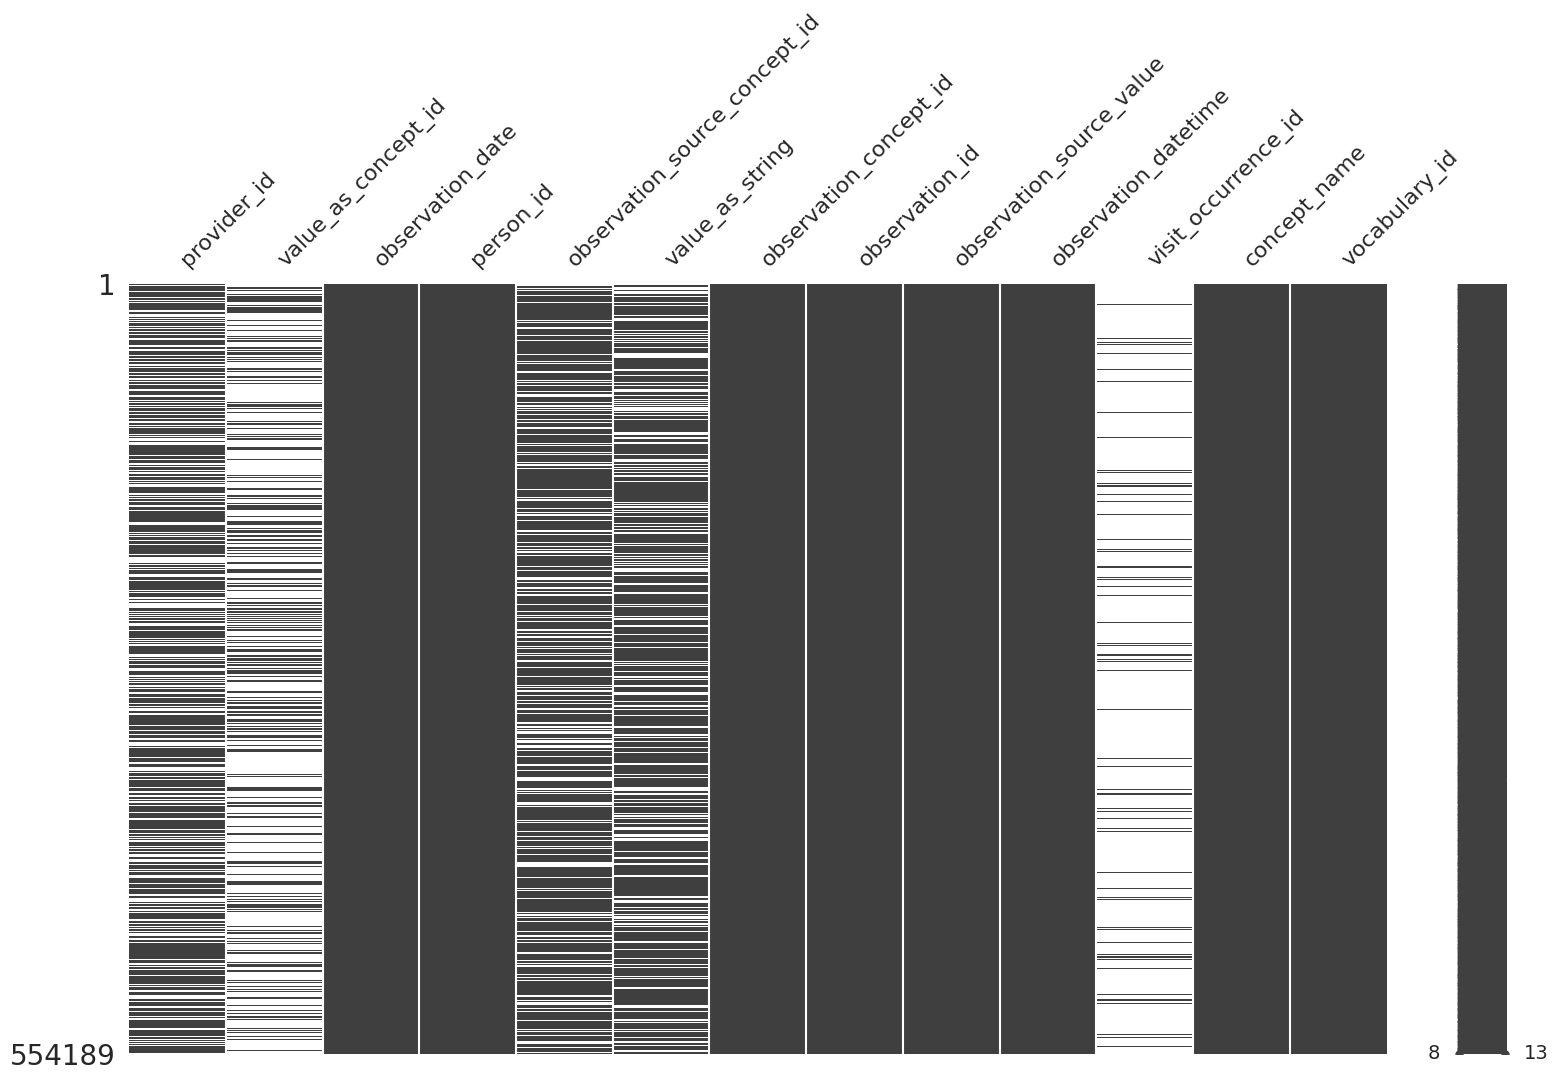

In [25]:
#Visualize cleaned dataset
import missingno as msno
msno.matrix(observations_with_names, figsize=(18, 10))

Therefore, we have 554,189 rows in observations_with_names that have concept_name values.

In [26]:
observations_with_names

,provider_id,value_as_concept_id,observation_date,person_id,observation_source_concept_id,value_as_string,observation_concept_id,observation_id,observation_source_value,observation_datetime,visit_occurrence_id,concept_name,vocabulary_id
0,NaN,NaN,2010-02-19,64285.0,44836678.0,1-5,440927.0,1540843.0,V5864,2010-02-19 01:21:31,NaN,High risk drug monitoring status,SNOMED
1,57104.0,NaN,2008-10-06,64285.0,NaN,NaN,4214956.0,438459.0,V155,2008-10-06 14:00:41,NaN,History of clinical finding in subject,SNOMED
11,645.0,NaN,2008-02-07,64285.0,44830822.0,.2,440927.0,1580201.0,V5863,2008-02-07 07:24:22,NaN,High risk drug monitoring status,SNOMED
20,231463.0,NaN,2009-12-23,64285.0,44820462.0,5-10,440922.0,1404510.0,V5867,2009-12-23 02:17:21,NaN,Diabetic on insulin,SNOMED
27,1445.0,4095430.0,2009-03-24,64285.0,44829615.0,54,4167217.0,110333.0,V190,2009-03-24 04:34:41,NaN,Family history of clinical finding,SNOMED
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1598349,271469.0,NaN,2008-02-20,55621.0,44821509.0,1-6,4214956.0,503833.0,V1200,2008-02-20 07:24:44,NaN,History of clinical finding in subject,SNOMED
1598350,157021.0,192367.0,2009-11-23,55621.0,44833113.0,1-3,4186037.0,885644.0,V518,2009-11-23 09:09:41,NaN,Aftercare,SNOMED
1598356,163924.0,NaN,2009-09-25,55621.0,44836674.0,32,4032376.0,141390.0,V571,2009-09-25 01:13:39,NaN,Physical rehabilitation therapy procedure,SNOMED
1598359,478474.0,NaN,2009-05-04,55621.0,44836677.0,NaN,4081759.0,727708.0,V5844,2009-05-04 07:09:27,NaN,Transplant follow-up,SNOMED


What do these columns that we have data for mean?

*   observation_type_concept_id: entity source for observation, like insurance claim or EHR system
*   provider_id: provider associated with observation
*   value_as_concept_id: captures clinical context?
*   observation_date: date when observation was obtained
*   person_id: patient associated with observation
*   observation_source_concept_id: represents the concept ID corresponding to the original observation_source_value in the source data
*   value_as_string: string value of observation, if applicable
*   **observation_concept_id**: mapped from observation_source_concept_id, standard representation of an observation
*   observation_id: unique ID given for observation record
*   observation_source_value: the exact code from the source before transformation to OMOP format
*   observation_datetime: date and time of observation
*   visit_occurence_id: possibly maps to visit table?
*   **concept_name**: an unambiguous, meaningful and descriptive name for the concept, which is associated with observation_concept_id
*   vocabulary_id: coding system of concept_name

In [27]:
# Display unique values in the concept_name column
unique_concept_names = observations_with_names['concept_name'].unique()
unique_concept_names.shape[0]

83

In [28]:
# Count the frequency of each concept_name
concept_name_counts = observations_with_names['concept_name'].value_counts()
# Display the first 10 unique concept_name values
print(concept_name_counts[:50])

concept_name
High risk drug monitoring status                                   154704
History of clinical finding in subject                             152443
Postoperative care                                                  42806
Diabetic on insulin                                                 29891
Family history of clinical finding                                  27722
Aftercare                                                           25598
Cardiac pacemaker in situ                                           17393
Follow-up encounter                                                 10648
Fall                                                                10469
Physical rehabilitation therapy procedure                            7840
Follow-up orthopedic assessment                                      6969
Automatic implantable cardiac defibrillator in situ                  6018
Accident                                                             5100
Fall on same level from s

## Austin: Drug Table Exploration
1. create a shortened path to person for train, test, and concept codes

In [29]:
drug_train = train['drug_exposure.csv']
drug_test = test['drug_exposure.csv']
drug_cc = cc['drug_exposure_concepts.csv']

2. Delete columnns with only NA's

In [30]:
print(drug_train.shape)
print(drug_train['person_id'].nunique())
drug_train.isna().sum()
#the folllowing columns had all NA's refills, drug_exposure_end_date, route_concept_id, lot_number, sig, route_source_value, dose_unit_source_value,drug_exposure_end_datetime, visit_detail_id, stop_reason


(357497, 23)
97916


,0
person_id,0
drug_exposure_start_date,40934
refills,357497
drug_source_value,40934
drug_exposure_end_date,357497
route_concept_id,357497
quantity,201203
lot_number,357497
days_supply,297703
sig,357497


In [31]:
#remove columns with all NA's
drug_train.drop(columns=['refills', 'drug_exposure_end_date', 'route_concept_id', 'lot_number', 'sig', 'route_source_value', 'dose_unit_source_value', 'drug_exposure_end_datetime', 'visit_detail_id', 'stop_reason'], inplace=True)

3. Add columns for names of drug_concept_id, drug_type_concept_id, and drug_source_concept_id.
Could not find the drug_type_concept_id and drug_source_concept_id concept codes in cc table AND couldn't find them online
4. Drop source_value columns, provider_id, drug_exposure_id, visit_occurence_id, vocabulary_id

In [32]:
#convert concept dataset 'race_concept_id' data type to match the training dataset 'race_concept_id' data type
#merge the concept table and the training table on 'race_concept_id'
merged_drug_train = drug_train.merge(
    drug_cc,
    how='left',
    left_on='drug_concept_id',
    right_on='drug_concept_id'
)

#rename 'concept_name' column to 'race'
merged_drug_train.rename(columns={'concept_name': 'drug'}, inplace=True)

#drop extra columns
merged_drug_train.drop(columns=['vocabulary_id'], inplace=True)

merged_drug_train.head()

,person_id,drug_exposure_start_date,drug_source_value,quantity,days_supply,drug_type_concept_id,drug_source_concept_id,provider_id,drug_exposure_id,drug_exposure_start_datetime,verbatim_end_date,drug_concept_id,visit_occurrence_id,drug
0,106959.0,2009-08-26,61392018839,NaN,NaN,38000175.0,44988429.0,NaN,3134766.0,2009-08-26 23:56:02,2009-11-24,19133578.0,NaN,NaN
1,106959.0,2009-12-07,00223415303,0.0,NaN,38000175.0,45197205.0,NaN,3341301.0,2009-12-07 11:24:22,2016-05-27,909166.0,NaN,NaN
2,116511.0,2009-02-12,49856021201,30.0,NaN,38000175.0,44966375.0,NaN,1390829.0,2009-02-12 04:31:09,2011-06-23,19133839.0,NaN,NaN
3,116511.0,2008-07-04,51129438502,NaN,NaN,38000175.0,45274272.0,NaN,2710818.0,2008-07-04 04:02:22,2010-02-04,19019116.0,272277.0,Lovastatin 20 MG Oral Tablet
4,17393.0,2008-10-17,58016610301,NaN,NaN,38000175.0,45089953.0,NaN,5515847.0,2008-10-17 10:12:49,NaN,40224320.0,NaN,NaN


## Austin: Exploring Visit_Occurance Table

In [33]:
visit_train = train['visit_occurrence.csv']
visit_test = test['visit_occurrence.csv']
visit_cc = cc['visit_occurrence_concepts.csv']

In [34]:
visit_train.head()

,provider_id,visit_start_date,preceding_visit_occurrence_id,admitting_source_value,person_id,discharge_to_source_value,care_site_id,visit_occurrence_id,visit_source_value,visit_end_date,visit_start_datetime,visit_concept_id,admitting_source_concept_id,visit_source_concept_id,visit_type_concept_id,discharge_to_concept_id,visit_end_datetime
0,NaN,2009-10-02,NaN,NaN,129617.0,NaN,4057.0,1863806,887153388320050,NaN,2009-10-02 05:15:48,0,44814675.0,NaN,44818517,44814705.0,NaN
1,NaN,2008-06-27,NaN,NaN,129971.0,NaN,20141.0,1981327,542052281252242,NaN,2008-06-27 06:22:51,9202,44814675.0,NaN,44818517,NaN,2008-06-27 12:20:32
2,NaN,2008-12-23,NaN,NaN,36583.0,NaN,19814.0,1911457,887643388534706,2008-12-23,2008-12-23 09:45:27,0,NaN,NaN,44818517,44814705.0,2008-12-23 16:53:50
3,NaN,2008-03-24,NaN,NaN,2217.0,NaN,9948.0,4798297,887063387982378,NaN,2008-03-24 16:49:19,0,44814683.0,NaN,44818517,44814705.0,NaN
4,NaN,2008-12-05,NaN,NaN,69007.0,NaN,33601.0,476064,887413385658720,NaN,2008-12-05 03:16:57,0,44814675.0,NaN,44818517,44814705.0,NaN


In [35]:
visit_train.nunique()

,0
provider_id,30863
visit_start_date,896
preceding_visit_occurrence_id,0
admitting_source_value,0
person_id,97916
discharge_to_source_value,0
care_site_id,141837
visit_occurrence_id,943947
visit_source_value,943947
visit_end_date,897


In [36]:
visit_train.isnull().sum()

,0
provider_id,1069690
visit_start_date,0
preceding_visit_occurrence_id,1108648
admitting_source_value,1108648
person_id,0
discharge_to_source_value,1108648
care_site_id,1947
visit_occurrence_id,0
visit_source_value,0
visit_end_date,663081


<Axes: >

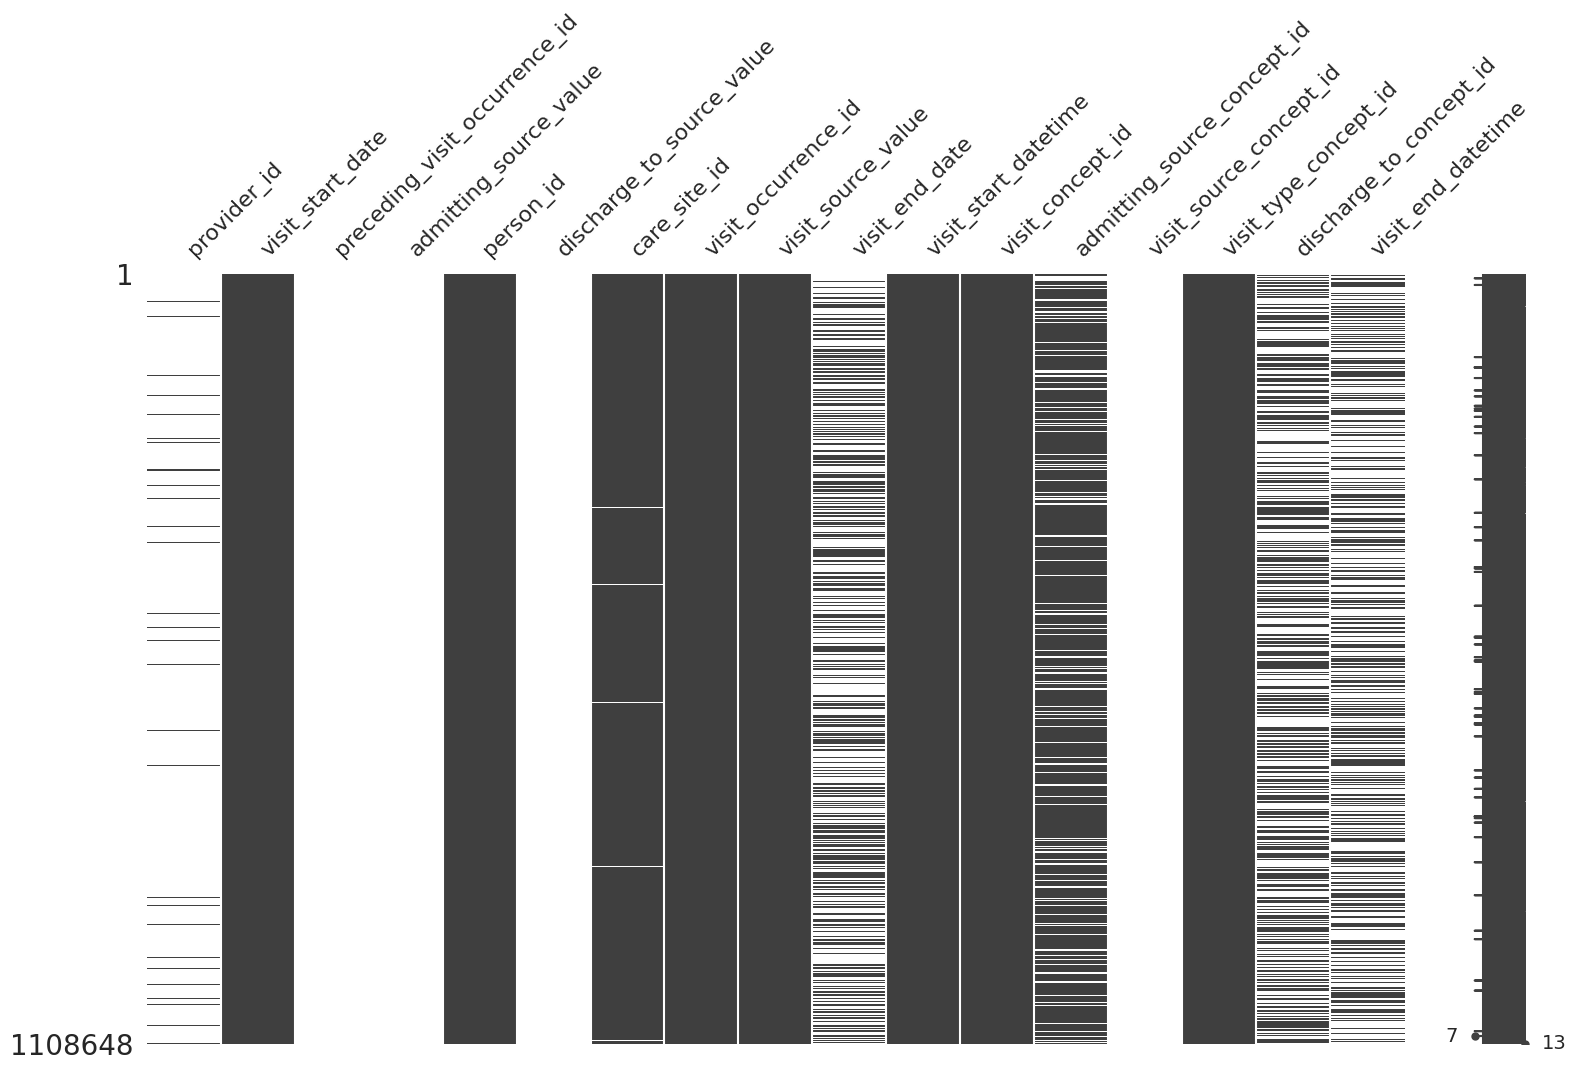

In [37]:
msno.matrix(visit_train, figsize=(18, 10))

## Natalie: Exploring Conditions Table

In [38]:
train['condition_occurrence.csv'].head()

,provider_id,visit_detail_id,condition_start_datetime,condition_end_datetime,condition_source_concept_id,person_id,condition_status_source_value,condition_end_date,condition_start_date,condition_status_concept_id,condition_type_concept_id,condition_concept_id,stop_reason,condition_source_value,condition_occurrence_id,visit_occurrence_id
0,NaN,NaN,2008-11-20,NaN,44829639.0,115208.0,NaN,NaN,2008-11-20,4230359.0,38000230.0,312922.0,NaN,V4581,9070047.0,NaN
1,NaN,NaN,2009-02-18,NaN,44825447.0,115208.0,NaN,NaN,2009-02-18,4230359.0,38000230.0,43020432.0,NaN,44021,5258637.0,NaN
2,NaN,NaN,2008-08-24,NaN,44828074.0,115208.0,NaN,NaN,2008-08-24,NaN,38000230.0,75354.0,NaN,7329,12839271.0,NaN
3,NaN,NaN,2010-05-14,NaN,44830080.0,115208.0,NaN,NaN,2010-05-14,4230359.0,38000230.0,42872402.0,NaN,41401,4019921.0,2042432.0
4,NaN,NaN,2009-02-08,NaN,44828981.0,115208.0,NaN,NaN,2009-02-08,4230359.0,38000230.0,316999.0,NaN,4279,4022174.0,NaN


In [39]:
train['condition_occurrence.csv'].nunique()

,0
provider_id,30948
visit_detail_id,0
condition_start_datetime,901
condition_end_datetime,886
condition_source_concept_id,8894
person_id,97916
condition_status_source_value,0
condition_end_date,881
condition_start_date,901
condition_status_concept_id,1


In [40]:
train['condition_occurrence.csv'].isnull().sum()

,0
provider_id,1796868
visit_detail_id,1836041
condition_start_datetime,34704
condition_end_datetime,1801992
condition_source_concept_id,34704
person_id,0
condition_status_source_value,1836041
condition_end_date,1801994
condition_start_date,34704
condition_status_concept_id,936014


In [41]:
# Perform a left join to merge condition data with their descriptions
condition_with_names = pd.merge(
    train['condition_occurrence.csv'],
    cc['condition_occurrence_concepts.csv'],
    on='condition_concept_id',
    how='left'  # Retain all rows from condition
)

# Display the first few rows of the merged dataframe
condition_with_names

,provider_id,visit_detail_id,condition_start_datetime,condition_end_datetime,condition_source_concept_id,person_id,condition_status_source_value,condition_end_date,condition_start_date,condition_status_concept_id,condition_type_concept_id,condition_concept_id,stop_reason,condition_source_value,condition_occurrence_id,visit_occurrence_id,concept_name,vocabulary_id
0,NaN,NaN,2008-11-20,NaN,44829639.0,115208.0,NaN,NaN,2008-11-20,4230359.0,38000230.0,312922.0,NaN,V4581,9070047.0,NaN,Coronary bypass graft finding,SNOMED
1,NaN,NaN,2009-02-18,NaN,44825447.0,115208.0,NaN,NaN,2009-02-18,4230359.0,38000230.0,43020432.0,NaN,44021,5258637.0,NaN,Atherosclerosis of native arteries of the extr...,SNOMED
2,NaN,NaN,2008-08-24,NaN,44828074.0,115208.0,NaN,NaN,2008-08-24,NaN,38000230.0,75354.0,NaN,7329,12839271.0,NaN,Osteochondropathy,SNOMED
3,NaN,NaN,2010-05-14,NaN,44830080.0,115208.0,NaN,NaN,2010-05-14,4230359.0,38000230.0,42872402.0,NaN,41401,4019921.0,2042432.0,Coronary arteriosclerosis in native artery,SNOMED
4,NaN,NaN,2009-02-08,NaN,44828981.0,115208.0,NaN,NaN,2009-02-08,4230359.0,38000230.0,316999.0,NaN,4279,4022174.0,NaN,Conduction disorder of the heart,SNOMED
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1836036,NaN,NaN,NaN,NaN,NaN,151669.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,57244.0,NaN,NaN
1836037,NaN,NaN,NaN,NaN,NaN,151678.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1836038,NaN,NaN,NaN,NaN,NaN,151681.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1836039,NaN,NaN,NaN,NaN,NaN,151683.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [42]:
condition_with_names['person_id'].nunique()

97916

<Axes: >

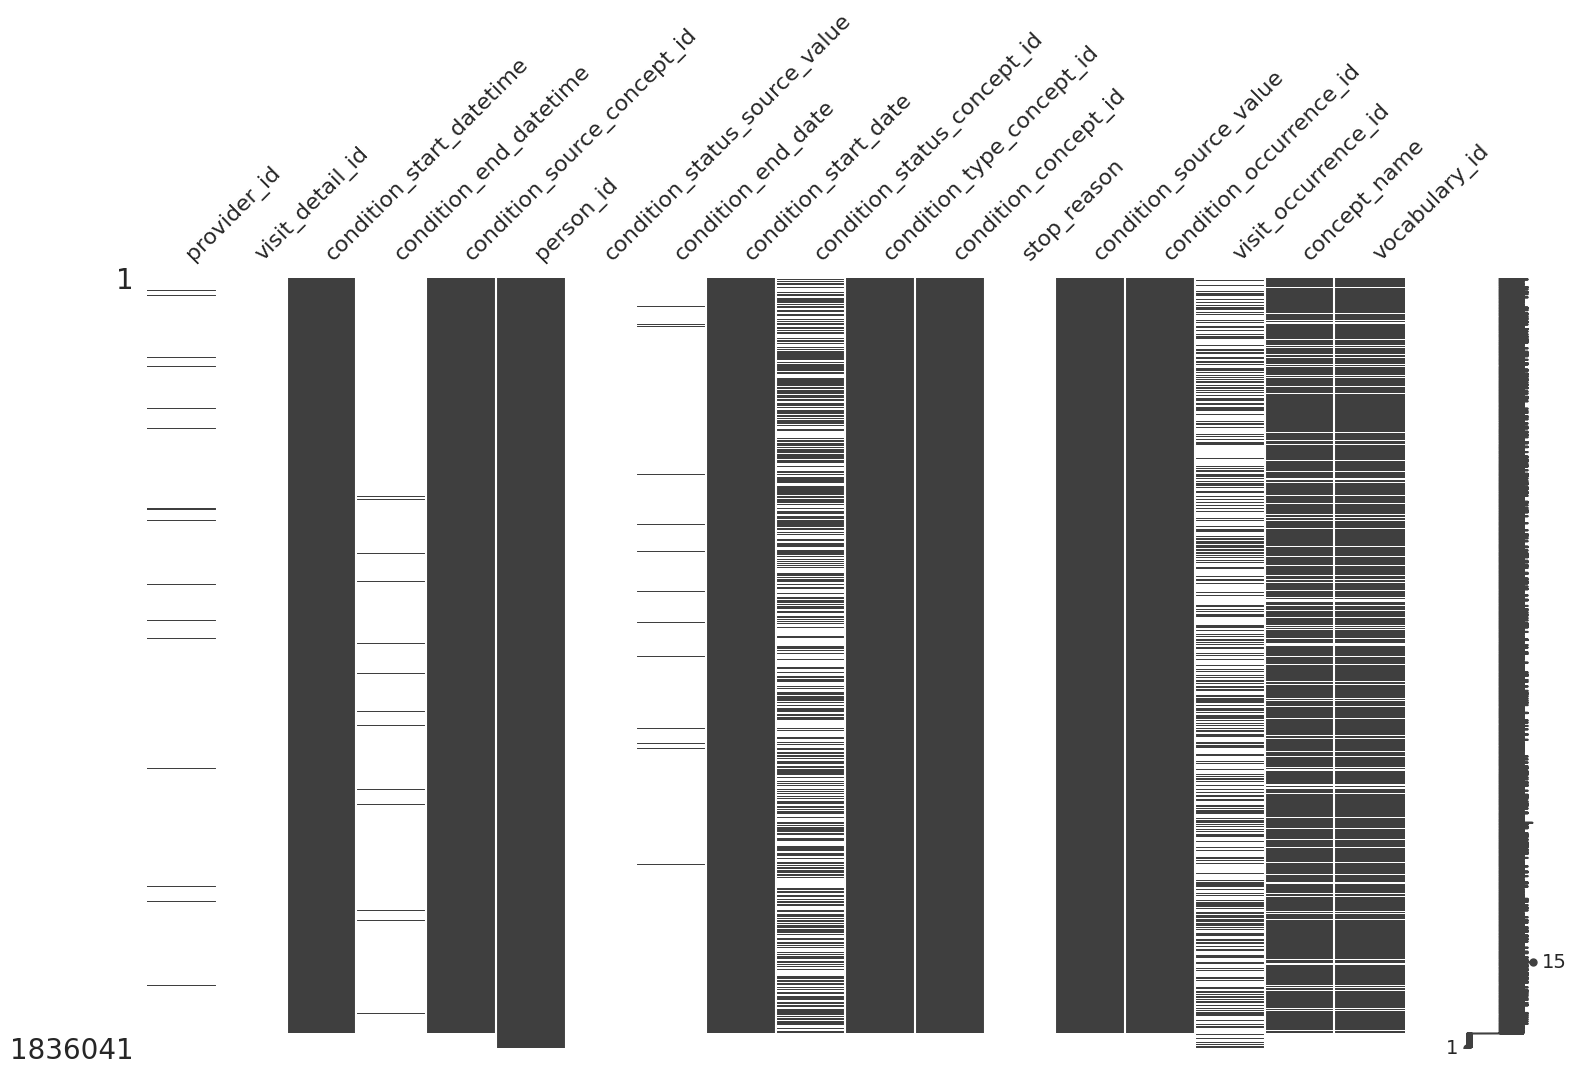

In [43]:

# Display a visualization of missing data
msno.matrix(condition_with_names, figsize=(18, 10))

# Feature Extraction

## Hanane: Outcome

Here are the following steps we will take to create Table_2:


1.   Merge visit Occurence and visit Occurence concepts to get Concept_name.
2.   Drop Additional columns we wont use.
3.   Join the newly created Table with Death table.
4.   Filter to only keep the last visit date
5.   Create a New column Calculating the number of days before death
6.   Add a Binary column that states 0 if death over 180 or no death, 1 if death under 180.

In [44]:
# Load visit_occurrence and visit_occurrence_concepts datasets
visit_occurrence=train['visit_occurrence.csv']
visit_occurrence_concepts=cc['visit_occurrence_concepts.csv']

In [45]:
#join visit_occurence and visit_occurrence_concepts to find the type of visit
visit_occurrence_merge = pd.merge(visit_occurrence, visit_occurrence_concepts , on='visit_concept_id', how='outer')
visit_occurrence_merge = visit_occurrence_merge.drop(['admitting_source_value','visit_source_concept_id','preceding_visit_occurrence_id','discharge_to_source_value', 'provider_id','admitting_source_concept_id','visit_concept_id','visit_type_concept_id'], axis=1)
visit_occurrence_merge.head()

,visit_start_date,person_id,care_site_id,visit_occurrence_id,visit_source_value,visit_end_date,visit_start_datetime,discharge_to_concept_id,visit_end_datetime,concept_name,vocabulary_id
0,2009-10-02,129617.0,4057.0,1863806.0,8.871534e+14,NaN,2009-10-02 05:15:48,44814705.0,NaN,NaN,NaN
1,2008-12-23,36583.0,19814.0,1911457.0,8.876434e+14,2008-12-23,2008-12-23 09:45:27,44814705.0,2008-12-23 16:53:50,NaN,NaN
2,2008-03-24,2217.0,9948.0,4798297.0,8.870634e+14,NaN,2008-03-24 16:49:19,44814705.0,NaN,NaN,NaN
3,2008-12-05,69007.0,33601.0,476064.0,8.874134e+14,NaN,2008-12-05 03:16:57,44814705.0,NaN,NaN,NaN
4,2009-02-17,109492.0,6312.0,624548.0,8.870434e+14,NaN,2009-02-17 02:07:07,NaN,NaN,NaN,NaN


In [46]:
death=train['death.csv']
death= death.drop(['death_type_concept_id','cause_concept_id','cause_source_value','cause_source_concept_id'], axis=1)
death.head()

,person_id,death_date,death_datetime
0,144964,2010-11-18,2010-11-18 16:13:45
1,47287,2010-01-16,2010-01-16 22:25:49
2,128284,2010-12-28,2010-12-28 06:47:01
3,47064,2010-04-19,2010-04-19 20:37:36
4,42217,2009-10-08,2009-10-08 00:52:17


In [47]:
#Join Visit Occurrence and Death Table
Joined_visit_occurence_and_death = pd.merge(visit_occurrence_merge, death , on='person_id', how='outer')
#only keep the latest visits
# Find the latest visit for each patient
latest_visits = Joined_visit_occurence_and_death.loc[Joined_visit_occurence_and_death.groupby('person_id')['visit_start_datetime'].idxmax()]

# Reset index for a clean output
latest_visits = latest_visits.reset_index(drop=True)
latest_visits.head()

,visit_start_date,person_id,care_site_id,visit_occurrence_id,visit_source_value,visit_end_date,visit_start_datetime,discharge_to_concept_id,visit_end_datetime,concept_name,vocabulary_id,death_date,death_datetime
0,2010-03-12,0.0,10759.0,462902.0,5.428423e+14,NaN,2010-03-12 05:33:02,NaN,NaN,Outpatient Visit,Visit,NaN,NaN
1,2010-02-20,5.0,1514.0,3677416.0,5.424023e+14,2010-02-20,2010-02-20 16:32:08,44814705.0,2010-02-20 01:27:34,Outpatient Visit,Visit,NaN,NaN
2,2010-04-29,6.0,44547.0,2709063.0,8.879934e+14,2010-04-30,2010-04-29 22:18:32,NaN,NaN,NaN,NaN,NaN,NaN
3,2010-03-25,7.0,24732.0,2014269.0,8.878034e+14,2010-03-25,2010-03-25 16:42:43,NaN,2010-03-25 20:10:27,NaN,NaN,NaN,NaN
4,2010-01-19,8.0,11814.0,3000253.0,8.872934e+14,2010-01-19,2010-01-19 20:12:42,44814705.0,NaN,NaN,NaN,NaN,NaN


In [48]:
#Convert to datetime
latest_visits['visit_start_datetime'] = pd.to_datetime(latest_visits['visit_start_datetime'])

latest_visits['death_date'] = pd.to_datetime(latest_visits['death_date'])
#New column calculating difference between Death date and Lastest Visit
latest_visits['days_to_death'] = np.where(
    latest_visits['death_date'].notna(),  # death_date is not NaN
    (latest_visits['death_date'] - latest_visits['visit_start_datetime']).dt.days,  # Calculate difference in days
    np.nan  # Else, keep NaN
)

In [49]:
# Add a column for classification: 1 for True Positive, 0 for True Negative
latest_visits['classification'] = np.where(
    (latest_visits['days_to_death'] <= 180) & (latest_visits['days_to_death'].notna()),  # True Positive
    1,  # True Positive: Death within 180 days
    0   # True Negative: Death after 180 days or no death
)

# Count True Positives and True Negatives
true_positive_count = latest_visits['classification'].sum()  # Count of 1s (True Positives)
true_negative_count = len(latest_visits) - true_positive_count  # Count of 0s (True Negatives)

print(f"Number of True Positives (death within 180 days): {true_positive_count}")
print(f"Number of True Negatives (no death or death after 180 days): {true_negative_count}")


Number of True Positives (death within 180 days): 520
Number of True Negatives (no death or death after 180 days): 97396


In [50]:
# joining latest_visits and demographics
Table_2 = pd.merge(Table_1, latest_visits, on='person_id', how='outer')
Table_2

,person_id,age,gender_Male,gender_nan,race_Asian,race_Black or African American,race_Native Hawaiian or Other Pacific Islander,race_Unknown,race_White,race_nan,...,visit_end_date,visit_start_datetime,discharge_to_concept_id,visit_end_datetime,concept_name,vocabulary_id,death_date,death_datetime,days_to_death,classification
0,0,95.0,0,0,0,0,0,1,0,0,...,NaN,2010-03-12 05:33:02,NaN,NaN,Outpatient Visit,Visit,NaT,NaN,NaN,0.0
1,5,83.0,0,0,0,0,1,0,0,0,...,2010-02-20,2010-02-20 16:32:08,44814705.0,2010-02-20 01:27:34,Outpatient Visit,Visit,NaT,NaN,NaN,0.0
2,6,42.0,1,0,0,0,0,0,1,0,...,2010-04-30,2010-04-29 22:18:32,NaN,NaN,NaN,NaN,NaT,NaN,NaN,0.0
3,7,80.0,1,0,0,0,0,0,0,0,...,2010-03-25,2010-03-25 16:42:43,NaN,2010-03-25 20:10:27,NaN,NaN,NaT,NaN,NaN,0.0
4,8,85.0,1,0,0,0,0,0,0,0,...,2010-01-19,2010-01-19 20:12:42,44814705.0,NaN,NaN,NaN,NaT,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97913,151679,69.0,1,0,0,0,0,0,1,0,...,NaN,2010-03-24 12:16:23,44814705.0,2010-03-24 10:23:03,NaN,NaN,2011-01-06,2011-01-06 22:31:16,287.0,0.0
97914,151680,98.0,1,0,0,0,0,0,0,1,...,NaN,2008-06-05 21:15:51,NaN,NaN,NaN,NaN,NaT,NaN,NaN,0.0
97915,151681,82.0,1,0,0,0,0,0,0,0,...,2008-06-07,2008-06-07 02:39:33,NaN,NaN,NaN,NaN,NaT,NaN,NaN,0.0
97916,151683,75.0,1,0,1,0,0,0,0,0,...,NaN,2009-09-08 14:59:04,44814705.0,2009-09-08 10:47:42,NaN,NaN,NaT,NaN,NaN,0.0


## Hanane: Conditions

In [51]:
#load condition occurence and concept
condition_occurrence=train['condition_occurrence.csv']
condition_occurrence_concepts=cc['condition_occurrence_concepts.csv']
# Merge the two tables to find the condition name
condition_occurrence = pd.merge(condition_occurrence, condition_occurrence_concepts, on='condition_concept_id', how='outer')
#rename 'concept_name' column to 'Condition name'
condition_occurrence.rename(columns={'concept_name': 'Condition name'}, inplace=True)
condition_occurrence.head()

,provider_id,visit_detail_id,condition_start_datetime,condition_end_datetime,condition_source_concept_id,person_id,condition_status_source_value,condition_end_date,condition_start_date,condition_status_concept_id,condition_type_concept_id,condition_concept_id,stop_reason,condition_source_value,condition_occurrence_id,visit_occurrence_id,Condition name,vocabulary_id
0,NaN,NaN,2009-03-25,NaN,44836035.0,41197.0,NaN,NaN,2009-03-25,NaN,38000230.0,0.0,NaN,5859,923885.0,4746703.0,NaN,NaN
1,NaN,NaN,2009-11-08,NaN,44836158.0,32666.0,NaN,NaN,2009-11-08,4230359.0,38000230.0,0.0,NaN,70712,5433043.0,5248816.0,NaN,NaN
2,NaN,NaN,2009-12-10,NaN,44837310.0,92473.0,NaN,NaN,2009-12-10,4230359.0,38000230.0,0.0,NaN,69283,98732.0,1539024.0,NaN,NaN
3,NaN,NaN,2010-03-06,NaN,44832477.0,48865.0,NaN,NaN,2010-03-06,4230359.0,38000230.0,0.0,NaN,5715,8223702.0,4877284.0,NaN,NaN
4,NaN,NaN,2009-12-14,NaN,44836035.0,122298.0,NaN,NaN,2009-12-14,4230359.0,38000230.0,0.0,NaN,5859,5288955.0,2736428.0,NaN,NaN


In [52]:
condition_occurrence = condition_occurrence.drop(['provider_id','visit_detail_id','condition_source_concept_id','condition_status_source_value',
                                                  'condition_status_concept_id','condition_type_concept_id','condition_concept_id','stop_reason',
                                                  'condition_source_value','condition_occurrence_id','visit_occurrence_id','vocabulary_id'],axis=1)
condition_occurrence['Condition name'] = condition_occurrence['Condition name'].str.lower()
condition_occurrence.head()

,condition_start_datetime,condition_end_datetime,person_id,condition_end_date,condition_start_date,Condition name
0,2009-03-25,NaN,41197.0,NaN,2009-03-25,NaN
1,2009-11-08,NaN,32666.0,NaN,2009-11-08,NaN
2,2009-12-10,NaN,92473.0,NaN,2009-12-10,NaN
3,2010-03-06,NaN,48865.0,NaN,2010-03-06,NaN
4,2009-12-14,NaN,122298.0,NaN,2009-12-14,NaN


In [53]:
# Count the frequency of each condition name
concept_name_counts = condition_occurrence['Condition name'].value_counts()
# Display the first 10 unique concept_name values
print(concept_name_counts[:50])


Condition name
type 2 diabetes mellitus                                      77400
atrial fibrillation                                           35920
chest pain                                                    31039
pure hypercholesterolemia                                     29292
hypothyroidism                                                23137
coronary arteriosclerosis in native artery                    22591
malaise and fatigue                                           21567
congestive heart failure                                      20809
urinary tract infectious disease                              20301
low back pain                                                 19132
coronary arteriosclerosis                                     15879
dyspnea                                                       14538
pain in limb                                                  14201
abdominal pain                                                12404
end-stage renal disease          

We will pick the following Conditions


---
From Charlson Comorbidity Index
*   Myocardial infarction
*   Congestive Heart Failure
*   Peripheral vascular disease
*   Cerebrovascular accident
*   Peripheral vascular disease
*   Liver disease

Other
*   End-Stage Renal Disease
*   Stroke








In [54]:
# Define a list of keywords related to Charlson Comorbidity Index conditions
charlson_keywords = [
    'myocardial infarction',
    'congestive heart failure',
    'peripheral vascular disease',
    'cerebrovascular',
    'end-stage',
    'stroke'
    'liver'
]
# Define exclusion keywords ("without")
exclusion_keywords = ['without']

# Create a DataFrame for easier filtering
concept_name_df = concept_name_counts.reset_index()
concept_name_df.columns = ['Condition Name', 'Count']

# Keep rows where any of the keywords partially match the condition name
filtered_counts = concept_name_df[
    concept_name_df['Condition Name'].str.contains('|'.join(charlson_keywords), case=False, na=False) &
    ~ concept_name_df['Condition Name'].str.contains('|'.join(exclusion_keywords), case=False, na=False)
]

# Display the filtered results
filtered_counts



,Condition Name,Count
7,congestive heart failure,20809
14,end-stage renal disease,11770
197,acute myocardial infarction,1478
401,cerebrovascular disease,709
411,hemiplegia as late effect of cerebrovascular d...,692
583,peripheral vascular disease,448
638,acute myocardial infarction of anterior wall,399
647,hypertensive heart disease with congestive hea...,393
654,late effects of cerebrovascular disease,389
668,acute myocardial infarction of inferior wall,373


Now we will group our data

In [55]:
# Define grouping logic
def assign_group(condition_name):
    if 'myocardial infarction' in condition_name.lower():
        return 'Myocardial Infarction'
    elif 'congestive heart failure' in condition_name.lower():
        return 'Congestive Heart Failure'
    elif 'peripheral vascular disease' in condition_name.lower():
        return 'Peripheral Vascular Disease'
    elif 'cerebrovascular' in condition_name.lower() or 'stroke' in condition_name.lower() or 'hemiplegia' in condition_name.lower() or 'aphasia' in condition_name.lower():
        return 'Cerebrovascular Disease'
    elif 'end-stage' in condition_name.lower():
        return 'End-Stage Disease'
    elif 'liver' in condition_name.lower():
        return 'Liver Disease'
    else:
        return 'Other'

# Apply the grouping logic
concept_name_df['Grouped Conditions'] = concept_name_df['Condition Name'].apply(assign_group)

# Filter and group the counts as before
filtered_counts = concept_name_df[
    concept_name_df['Condition Name'].str.contains('|'.join(charlson_keywords), case=False, na=False) &
    ~ concept_name_df['Condition Name'].str.contains('|'.join(exclusion_keywords), case=False, na=False)
]

# Sort and display the results
grouped_counts = filtered_counts.groupby('Grouped Conditions').agg({'Count': 'sum'}).reset_index()

filtered_counts

,Condition Name,Count,Grouped Conditions
7,congestive heart failure,20809,Congestive Heart Failure
14,end-stage renal disease,11770,End-Stage Disease
197,acute myocardial infarction,1478,Myocardial Infarction
401,cerebrovascular disease,709,Cerebrovascular Disease
411,hemiplegia as late effect of cerebrovascular d...,692,Cerebrovascular Disease
583,peripheral vascular disease,448,Peripheral Vascular Disease
638,acute myocardial infarction of anterior wall,399,Myocardial Infarction
647,hypertensive heart disease with congestive hea...,393,Congestive Heart Failure
654,late effects of cerebrovascular disease,389,Cerebrovascular Disease
668,acute myocardial infarction of inferior wall,373,Myocardial Infarction


Note: we will pick the Condition names we are interested in drop duplicates

In [56]:
# Filter condition_occurrence for relevant conditions
filtered_conditions = condition_occurrence[
    condition_occurrence['Condition name'].str.contains('|'.join(charlson_keywords), case=False, na=False)
].copy()

# Ensure the 'Grouped Conditions' column is populated
filtered_conditions.loc[:, 'Grouped Conditions'] = filtered_conditions['Condition name'].apply(assign_group)

# Drop duplicate rows for the same person_id and Grouped Condition to ensure binary presence
filtered_conditions = filtered_conditions.drop_duplicates(subset=['person_id', 'Grouped Conditions'])

# Pivot the data: each grouped condition becomes a column, with 1 if the patient has it, 0 otherwise
condition_pivot = pd.crosstab(filtered_conditions['person_id'], filtered_conditions['Grouped Conditions'])

# Reset the index to make the DataFrame easier to work with
condition_pivot.reset_index(inplace=True)

# Display the reshaped table
condition_pivot.head()

Grouped Conditions,person_id,Cerebrovascular Disease,Congestive Heart Failure,End-Stage Disease,Myocardial Infarction,Peripheral Vascular Disease
0,6.0,1,1,1,0,0
1,8.0,0,1,0,0,0
2,24.0,1,1,1,0,0
3,25.0,0,0,1,0,0
4,38.0,0,1,1,0,0


### Merge conditions with table 2

In [57]:
# joining Table_2 and condition_pivot
Table_3 = pd.merge(Table_2, condition_pivot , on='person_id', how='outer')
Table_3 = Table_3.drop(['concept_name','vocabulary_id', 'death_date', 'death_datetime','days_to_death','visit_start_date', 'care_site_id', 'visit_occurrence_id', 'visit_source_value', 'visit_end_date',  'visit_start_datetime', 'discharge_to_concept_id', 'visit_end_datetime'],axis=1)
Table_3.head()

,person_id,age,gender_Male,gender_nan,race_Asian,race_Black or African American,race_Native Hawaiian or Other Pacific Islander,race_Unknown,race_White,race_nan,classification,Cerebrovascular Disease,Congestive Heart Failure,End-Stage Disease,Myocardial Infarction,Peripheral Vascular Disease
0,0,95.0,0,0,0,0,0,1,0,0,0.0,NaN,NaN,NaN,NaN,NaN
1,5,83.0,0,0,0,0,1,0,0,0,0.0,NaN,NaN,NaN,NaN,NaN
2,6,42.0,1,0,0,0,0,0,1,0,0.0,1.0,1.0,1.0,0.0,0.0
3,7,80.0,1,0,0,0,0,0,0,0,0.0,NaN,NaN,NaN,NaN,NaN
4,8,85.0,1,0,0,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0


For the patients with no conditions after a full merge we get Nan, so I edited it to be filled 0

In [58]:
# Identify columns in Table_3 that correspond to grouped conditions
grouped_condition_columns = [col for col in Table_3.columns if col in condition_pivot.columns]

# Replace NaN with 0 in those grouped condition columns
Table_3[grouped_condition_columns] = Table_3[grouped_condition_columns].fillna(0)

# Display the updated table (optional)
Table_3.head()

,person_id,age,gender_Male,gender_nan,race_Asian,race_Black or African American,race_Native Hawaiian or Other Pacific Islander,race_Unknown,race_White,race_nan,classification,Cerebrovascular Disease,Congestive Heart Failure,End-Stage Disease,Myocardial Infarction,Peripheral Vascular Disease
0,0,95.0,0,0,0,0,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,5,83.0,0,0,0,0,1,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,6,42.0,1,0,0,0,0,0,1,0,0.0,1.0,1.0,1.0,0.0,0.0
3,7,80.0,1,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
4,8,85.0,1,0,0,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0


### Add Condition Length?

## Natalie: Extracting High Risk Admission Type

In [59]:
# Define high-risk keywords
high_risk_keywords = ['hospice', 'palliative', 'icu', 'intensive care']

# Create a binary column 'high_risk_flag' if concept_name contains any high-risk keyword
observations_with_names['high_risk_admission'] = observations_with_names['concept_name'].str.contains(
    '|'.join(high_risk_keywords), case=False, na=False
).astype(int)

# Group by person_id to ensure a single row per person with the maximum value for the high-risk flag
high_risk_flags = observations_with_names.groupby('person_id')['high_risk_admission'].max().reset_index()

# Display the resulting DataFrame with the high-risk flag
print(high_risk_flags)

       person_id  high_risk_admission
0            0.0                    0
1            6.0                    0
2            9.0                    0
3           22.0                    0
4           24.0                    0
...          ...                  ...
40047   151674.0                    0
40048   151678.0                    0
40049   151680.0                    0
40050   151681.0                    0
40051   151683.0                    0

[40052 rows x 2 columns]


<ipython-input-59-1839a5e0adce>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  observations_with_names['high_risk_admission'] = observations_with_names['concept_name'].str.contains(


In [60]:
# Filter rows where high_risk_flag is 1
high_risk_patients = high_risk_flags[high_risk_flags['high_risk_admission'] == 1]

# Display the filtered rows
print(high_risk_patients)

       person_id  high_risk_admission
25          97.0                    1
32         126.0                    1
59         227.0                    1
64         250.0                    1
71         274.0                    1
...          ...                  ...
39989   151428.0                    1
40005   151498.0                    1
40006   151499.0                    1
40022   151558.0                    1
40036   151631.0                    1

[2823 rows x 2 columns]


In [61]:
# Merge the DataFrames on 'person_id'
Table_4 = pd.merge(Table_3, high_risk_flags, on='person_id', how='left')

# Fill any missing high_risk_admission values with 0 (assuming no risk if missing)
Table_4['high_risk_admission'] = Table_4['high_risk_admission'].fillna(0)

# Display the first few rows of the updated table_2
Table_4.head()

,person_id,age,gender_Male,gender_nan,race_Asian,race_Black or African American,race_Native Hawaiian or Other Pacific Islander,race_Unknown,race_White,race_nan,classification,Cerebrovascular Disease,Congestive Heart Failure,End-Stage Disease,Myocardial Infarction,Peripheral Vascular Disease,high_risk_admission
0,0,95.0,0,0,0,0,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5,83.0,0,0,0,0,1,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,6,42.0,1,0,0,0,0,0,1,0,0.0,1.0,1.0,1.0,0.0,0.0,0.0
3,7,80.0,1,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,8,85.0,1,0,0,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


## Natalie: Extracting Drugs

I first am going to generate a list of the top 1000 drugs based on frequency. I will research these outside of the notebook to generate categories of drugs that might be most relevant to our task.

In [62]:
merged_drug_train.head()

,person_id,drug_exposure_start_date,drug_source_value,quantity,days_supply,drug_type_concept_id,drug_source_concept_id,provider_id,drug_exposure_id,drug_exposure_start_datetime,verbatim_end_date,drug_concept_id,visit_occurrence_id,drug
0,106959.0,2009-08-26,61392018839,NaN,NaN,38000175.0,44988429.0,NaN,3134766.0,2009-08-26 23:56:02,2009-11-24,19133578.0,NaN,NaN
1,106959.0,2009-12-07,00223415303,0.0,NaN,38000175.0,45197205.0,NaN,3341301.0,2009-12-07 11:24:22,2016-05-27,909166.0,NaN,NaN
2,116511.0,2009-02-12,49856021201,30.0,NaN,38000175.0,44966375.0,NaN,1390829.0,2009-02-12 04:31:09,2011-06-23,19133839.0,NaN,NaN
3,116511.0,2008-07-04,51129438502,NaN,NaN,38000175.0,45274272.0,NaN,2710818.0,2008-07-04 04:02:22,2010-02-04,19019116.0,272277.0,Lovastatin 20 MG Oral Tablet
4,17393.0,2008-10-17,58016610301,NaN,NaN,38000175.0,45089953.0,NaN,5515847.0,2008-10-17 10:12:49,NaN,40224320.0,NaN,NaN


In [63]:
drug_counts = merged_drug_train['drug'].value_counts()
drug_counts_list = drug_counts[:1000].items()
for drug, count in drug_counts_list:
    print(f"{drug}: {count}")

Epoetin Alfa: 6249
Gemfibrozil 600 MG Oral Tablet: 1907
Omeprazole 20 MG Delayed Release Oral Capsule: 1875
Lovastatin 20 MG Oral Tablet: 1592
Simvastatin 40 MG Oral Tablet: 1528
Simvastatin 20 MG Oral Tablet: 1412
Lovastatin 40 MG Oral Tablet: 1355
Hydrochlorothiazide 50 MG Oral Tablet: 1274
Metformin hydrochloride 500 MG Oral Tablet: 1233
Furosemide 40 MG Oral Tablet: 1219
Glyburide 5 MG Oral Tablet: 1169
Hydrochlorothiazide 25 MG Oral Tablet: 1133
Lovastatin 10 MG Oral Tablet: 1124
Simvastatin 10 MG Oral Tablet: 1062
Glipizide 10 MG Oral Tablet: 1054
Furosemide 20 MG Oral Tablet: 1051
Lisinopril 10 MG Oral Tablet: 1011
Metformin hydrochloride 1000 MG Oral Tablet: 996
Lisinopril 20 MG Oral Tablet: 991
Atenolol 50 MG Oral Tablet: 971
Sulfasalazine 500 MG Oral Tablet: 937
Metoprolol Tartrate 50 MG Oral Tablet: 893
Lisinopril 5 MG Oral Tablet: 882
Pravastatin Sodium 40 MG Oral Tablet: 808
Propranolol Hydrochloride 40 MG Oral Tablet: 798
Midazolam: 781
Glipizide 5 MG Oral Tablet: 780
Dig

It appears that the categories of drugs most relevant to our task are cancer drugs, end-of-life drugs, and severe disease drugs.



*   Cancer drugs: Methotrexate, cyclophosphamide
*   Pallitative Care Drugs: Midazolam, haloperidol, Morphine, fentanyl, Methadone Hydrochloride, oxycodone hydrochloride, Hydromorphone
*   Serious Diseases Drugs: Epoetin, darbepoetin alfa, Bumetanide, Furosemide, Lisinopril, Digoxin, Warfarin Sodium


References for each drug:


*   Epoetin Alfa & darbepoetin alfa - https://www.fda.gov/drugs/postmarket-drug-safety-information-patients-and-providers/information-erythropoiesis-stimulating-agents-esa-epoetin-alfa-marketed-procrit-epogen-darbepoetin
*   Methotrexate - https://www.ncbi.nlm.nih.gov/books/NBK556114/
*   Midazolam & haloperidol  - https://www.mariecurie.org.uk/professionals/palliative-care-knowledge-zone/symptom-control/anticipatory-medicines#:~:text=Medicine%20for%20pain%20in%20palliative,%2C%20levomepromazine%2C%20midazolam%20or%20phenobarbital.
*   Bumetanide - https://www.ncbi.nlm.nih.gov/books/NBK559181/
*   Furosemide - https://www.ncbi.nlm.nih.gov/books/NBK499921/
*   Lisinopril - https://pubmed.ncbi.nlm.nih.gov/10852646/
*   Morphine - https://ncbi.nlm.nih.gov/books/NBK526115///
*   fentanyl - https://www.dea.gov/sites/default/files/2023-06/Fentanyl%202022%20Drug%20Fact%20Sheet-update.pdf
*   Methadone Hydrochloride - https://pmc.ncbi.nlm.nih.gov/articles/PMC1070723/
*   Digoxin - https://www.ncbi.nlm.nih.gov/books/NBK470313/  
*   cyclophosphamide - https://www.cancerresearchuk.org/about-cancer/treatment/drugs/cyclophosphamide  
*   oxycodone hydrochloride- https://www.nhs.uk/medicines/oxycodone/about-oxycodone/
*   Hydromorphone - https://www.dea.gov/factsheets/hydromorphone

In [64]:
# Define drug categories
cancer_drugs = ['Methotrexate', 'Cyclophosphamide']
palliative_care_drugs = [
    'Midazolam', 'Haloperidol', 'Morphine', 'Fentanyl',
    'Methadone Hydrochloride', 'Oxycodone Hydrochloride', 'Hydromorphone'
]
serious_disease_drugs = [
    'Epoetin', 'Darbepoetin Alfa', 'Bumetanide',
    'Furosemide', 'Lisinopril', 'Digoxin', 'Warfarin Sodium'
]

In [65]:
# Create flags for each drug category (case insensitive)
merged_drug_train['cancer_drug'] = merged_drug_train['drug'].apply(lambda x: 1 if pd.notnull(x) and any(drug.lower() in x.lower() for drug in cancer_drugs) else 0)
merged_drug_train['palliative_care_drug'] = merged_drug_train['drug'].apply(lambda x: 1 if pd.notnull(x) and any(drug.lower() in x.lower() for drug in palliative_care_drugs) else 0)
merged_drug_train['serious_disease_drug'] = merged_drug_train['drug'].apply(lambda x: 1 if pd.notnull(x) and any(drug.lower() in x.lower() for drug in serious_disease_drugs) else 0)

In [66]:
# Group by person_id and aggregate
merged_drug_train = merged_drug_train.groupby('person_id', as_index=False).agg({
    'cancer_drug': 'max',
    'palliative_care_drug': 'max',
    'serious_disease_drug': 'max'
})
merged_drug_train

,person_id,cancer_drug,palliative_care_drug,serious_disease_drug
0,0.0,0,0,0
1,5.0,0,0,0
2,6.0,0,0,0
3,7.0,0,0,0
4,8.0,0,0,0
...,...,...,...,...
97911,151679.0,0,0,0
97912,151680.0,0,0,1
97913,151681.0,0,0,0
97914,151683.0,0,0,0


In [67]:
# Merge back with outcome dataset
Table_5 = pd.merge(Table_4, merged_drug_train, on='person_id', how='left')
Table_5

,person_id,age,gender_Male,gender_nan,race_Asian,race_Black or African American,race_Native Hawaiian or Other Pacific Islander,race_Unknown,race_White,race_nan,classification,Cerebrovascular Disease,Congestive Heart Failure,End-Stage Disease,Myocardial Infarction,Peripheral Vascular Disease,high_risk_admission,cancer_drug,palliative_care_drug,serious_disease_drug
0,0,95.0,0,0,0,0,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5,83.0,0,0,0,0,1,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,6,42.0,1,0,0,0,0,0,1,0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,7,80.0,1,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,8,85.0,1,0,0,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97913,151679,69.0,1,0,0,0,0,0,1,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
97914,151680,98.0,1,0,0,0,0,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
97915,151681,82.0,1,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
97916,151683,75.0,1,0,1,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [68]:
# dropping NAs so models can run
Table_5_train = Table_5.dropna()

## Finalizing Training

In [69]:
# Create a lookup table that maps index to patient_id
lookup_table = Table_5_train['person_id'].reset_index()
y_train = Table_5_train['classification']
training = Table_5_train.drop('person_id', axis=1, inplace=False)
# Display the first few rows of the lookup table and updated feature matrix


In [70]:
y_train.shape

(97840,)

In [71]:
training.columns

Index(['age', 'gender_Male', 'gender_nan', 'race_Asian',
       'race_Black or African American',
       'race_Native Hawaiian or Other Pacific Islander', 'race_Unknown',
       'race_White', 'race_nan', 'classification', 'Cerebrovascular Disease',
       'Congestive Heart Failure', 'End-Stage Disease',
       'Myocardial Infarction', 'Peripheral Vascular Disease',
       'high_risk_admission', 'cancer_drug', 'palliative_care_drug',
       'serious_disease_drug'],
      dtype='object')

In [72]:
demographics_feature_matrix = training[['age', 'gender_Male', 'gender_nan', 'race_Asian',
       'race_Black or African American',
       'race_Native Hawaiian or Other Pacific Islander', 'race_Unknown',
       'race_White', 'race_nan',]]
conditions_and_demographics_feature_matrix = training[['age', 'gender_Male', 'gender_nan', 'race_Asian',
       'race_Black or African American',
       'race_Native Hawaiian or Other Pacific Islander', 'race_Unknown',
       'race_White', 'race_nan', 'Cerebrovascular Disease',
       'Congestive Heart Failure', 'End-Stage Disease',
       'Myocardial Infarction', 'Peripheral Vascular Disease',]]
feature_matrix = training[['age', 'gender_Male', 'gender_nan', 'race_Asian',
       'race_Black or African American',
       'race_Native Hawaiian or Other Pacific Islander', 'race_Unknown',
       'race_White', 'race_nan', 'Cerebrovascular Disease',
       'Congestive Heart Failure', 'End-Stage Disease',
       'Myocardial Infarction', 'Peripheral Vascular Disease',
       'high_risk_admission', 'cancer_drug', 'palliative_care_drug',
       'serious_disease_drug',]]



# Testing

In [73]:
# Set the directory containing your files
testdirectory = 'datasets_from_box/testing_set'
# Read all CSV files in the directory
test = {}
for filename in os.listdir(testdirectory):
    if filename.endswith('.csv'):
        filepath = os.path.join(testdirectory, filename)
        test[filename] = pd.read_csv(filepath)
test.keys()

<ipython-input-73-c3c2bfff21b2>:8: DtypeWarning: Columns (0,6,11,15) have mixed types. Specify dtype option on import or set low_memory=False.
  test[filename] = pd.read_csv(filepath)


dict_keys(['person.csv', 'condition_occurrence.csv', 'drug_exposure.csv', 'observation.csv', 'observation_period.csv', 'visit_occurrence.csv', 'death.csv'])

In [74]:
#import concept codes data


# Set the directory containing your files
ccdirectory = 'datasets_from_box/concept_codes_final'

# Read all CSV files in the directory
cc = {}
for filename in os.listdir(ccdirectory):
    if filename.endswith('.csv'):
        filepath = os.path.join(ccdirectory, filename)
        cc[filename] = pd.read_csv(filepath)

In [75]:
cc.keys()

dict_keys(['observation_concepts.csv', 'condition_occurrence_concepts.csv', 'drug_exposure_concepts.csv', 'visit_occurrence_concepts.csv', 'person_concepts.csv', 'all_concepts.csv'])

## Hanane: Exploring Demographics of Person Table, and add Race and Gender Columns

Here are the following steps we will take to create Table_1:


1.   Load data and merge Person withe person_concept to get Race name.
2.   Drop Extra columns
3.   rename the column to Race
4.   Create a new Column for Gender

In [76]:
# Load person and person_concepts datasets
person=test['person.csv']
person_concepts=cc['person_concepts.csv']

In [77]:
#join race_concept_id
Table_1 = pd.merge(person, person_concepts , on='race_concept_id', how='outer')
#update table to remove irrelevant colums
Table_1 = Table_1.drop(['race_source_concept_id','ethnicity_source_concept_id','race_concept_id','provider_id', 'ethnicity_source_value','race_source_value','gender_source_concept_id','person_source_value','care_site_id','vocabulary_id','gender_source_value'], axis=1)
#rename 'concept_name' column to 'race'
Table_1.rename(columns={'concept_name': 'race'}, inplace=True)
#add a column 'gender' that displays names for codes in the 'gender_concept_id' column
Table_1['gender'] = Table_1['gender_concept_id'].replace({8507:'Female', 8532:'Male'})
Table_1['date_of_birth'] = pd.to_datetime(
    Table_1['year_of_birth'].astype('Int64').astype(str) + '-' +
    Table_1['month_of_birth'].astype('Int64').astype(str).str.zfill(2) + '-' +
    Table_1['day_of_birth'].astype('Int64').astype(str).str.zfill(2),
    errors='coerce'  # Handle invalid dates by setting them to NaT
)

In [78]:
# Load 'death.csv' data from the test dataset and drop unnecessary columns
death = test['death.csv']
death = death.drop(
    ['death_type_concept_id', 'cause_concept_id',
     'cause_source_value', 'cause_source_concept_id', 'death_datetime'],
    axis=1  # Drop specific columns that are not needed
)

# Merge the 'Table_1' dataset with the 'death' dataset on 'person_id'
# 'how=left' ensures all rows from Table_1 are retained and 'death' is matched where possible
Table_1_death = pd.merge(Table_1, death, on='person_id', how='left')

# Convert the 'death_date' column to datetime format
# 'errors=coerce' ensures invalid dates are converted to NaT (Not a Time)
Table_1_death['death_date'] = pd.to_datetime(Table_1_death['death_date'], errors='coerce')

# Calculate the 'age' column based on 'death_date' or current reference date
Table_1_death['age'] = np.where(
    Table_1_death['death_date'].isna(),  # If death_date is NaN (patient still alive)
    (pd.Timestamp('2019-02-01') - Table_1_death['date_of_birth']).dt.days // 365,  # Age as of Feb 1, 2019
    (Table_1_death['death_date'] - Table_1_death['date_of_birth']).dt.days // 365  # Age at death
)

# Drop columns that are no longer needed after calculating age
Table_1_death_drop = Table_1_death.drop(
    ['death_date', 'date_of_birth', 'month_of_birth', 'day_of_birth', 'year_of_birth', 'ethnicity_concept_id', 'location_id', 'gender_concept_id', 'birth_datetime'],
    axis=1  # Drop columns to clean up the dataset
)

# Display the first few rows of the cleaned dataset for verification
Table_1_death_drop.head()

# Update the original Table_1 variable to include the 'death' data
Table_1 = Table_1_death_drop
Table_1.head()  # Display the first few rows of the updated Table_1 dataset


,person_id,race,gender,age
0,40379,Asian,Male,98.0
1,3335,Asian,Male,61.0
2,44984,Asian,Male,77.0
3,25030,Asian,Female,78.0
4,37920,Asian,Male,77.0


In [79]:
# Convert 'gender' and 'race' into dummy/one-hot encoded columns
Table_1 = pd.get_dummies(Table_1, columns=['gender', 'race'], prefix=['gender', 'race'], drop_first=True, dtype=int, dummy_na=True)

# Display the first few rows of the updated DataFrame
Table_1.head()


,person_id,age,gender_Male,gender_nan,race_Asian,race_Black or African American,race_Native Hawaiian or Other Pacific Islander,race_Unknown,race_White,race_nan
0,40379,98.0,1,0,1,0,0,0,0,0
1,3335,61.0,1,0,1,0,0,0,0,0
2,44984,77.0,1,0,1,0,0,0,0,0
3,25030,78.0,0,0,1,0,0,0,0,0
4,37920,77.0,1,0,1,0,0,0,0,0


In [80]:
# Check for duplicate rows
duplicates = Table_1.duplicated()
# Count of duplicates
print(f"Number of duplicate rows: {duplicates.sum()}")

Number of duplicate rows: 0


## Natalie: Observation Table

In [81]:
# Remove fully missing columns
fully_missing_columns = test['observation.csv'].columns[test['observation.csv'].isnull().all()].tolist()

non_missing_observation = test['observation.csv'].drop(columns=fully_missing_columns)

# Remove the column 'observation_type_concept_id' from non_missing_observation
non_missing_observation = non_missing_observation.drop(columns=['observation_type_concept_id'])



In [82]:
# Perform a left join to merge observation data with their descriptions
observation_with_names = pd.merge(
    non_missing_observation,
    cc['observation_concepts.csv'],
    on='observation_concept_id',
    how='left'  # Retain all rows from observation.csv
)

# Display the first few rows of the merged dataframe
observation_with_names.shape[0]

1808926

In [83]:
#Ensure merge worked
observation_with_names.head()

,observation_source_value,observation_concept_id,observation_id,person_id,value_as_concept_id,observation_date,provider_id,observation_datetime,observation_source_concept_id,value_as_string,visit_occurrence_id,concept_name,vocabulary_id
0,V5861,440927.0,1000905.0,2697.0,NaN,2009-07-22,23835.0,2009-07-22 04:00:02,NaN,30-40,NaN,High risk drug monitoring status,SNOMED
1,V1046,4214956.0,1560324.0,2697.0,NaN,2008-01-24,NaN,2008-01-24 22:51:30,44820371.0,50,NaN,History of clinical finding in subject,SNOMED
2,Q0092,2720581.0,708113.0,2697.0,NaN,2008-11-01,NaN,2008-11-01 08:09:16,2720581.0,3-7,NaN,NaN,NaN
3,V1083,4214956.0,383129.0,2697.0,NaN,2008-09-02,365130.0,2008-09-02 21:01:19,44827307.0,1-3,NaN,History of clinical finding in subject,SNOMED
4,4048F,2108554.0,1247473.0,2697.0,4014023.0,2010-03-22,61588.0,2010-03-22 17:42:28,2108554.0,5-8,NaN,NaN,NaN


In [84]:
# Filter rows with non-missing concept_name
observations_with_names = observation_with_names[observation_with_names['concept_name'].notnull()]

<Axes: >

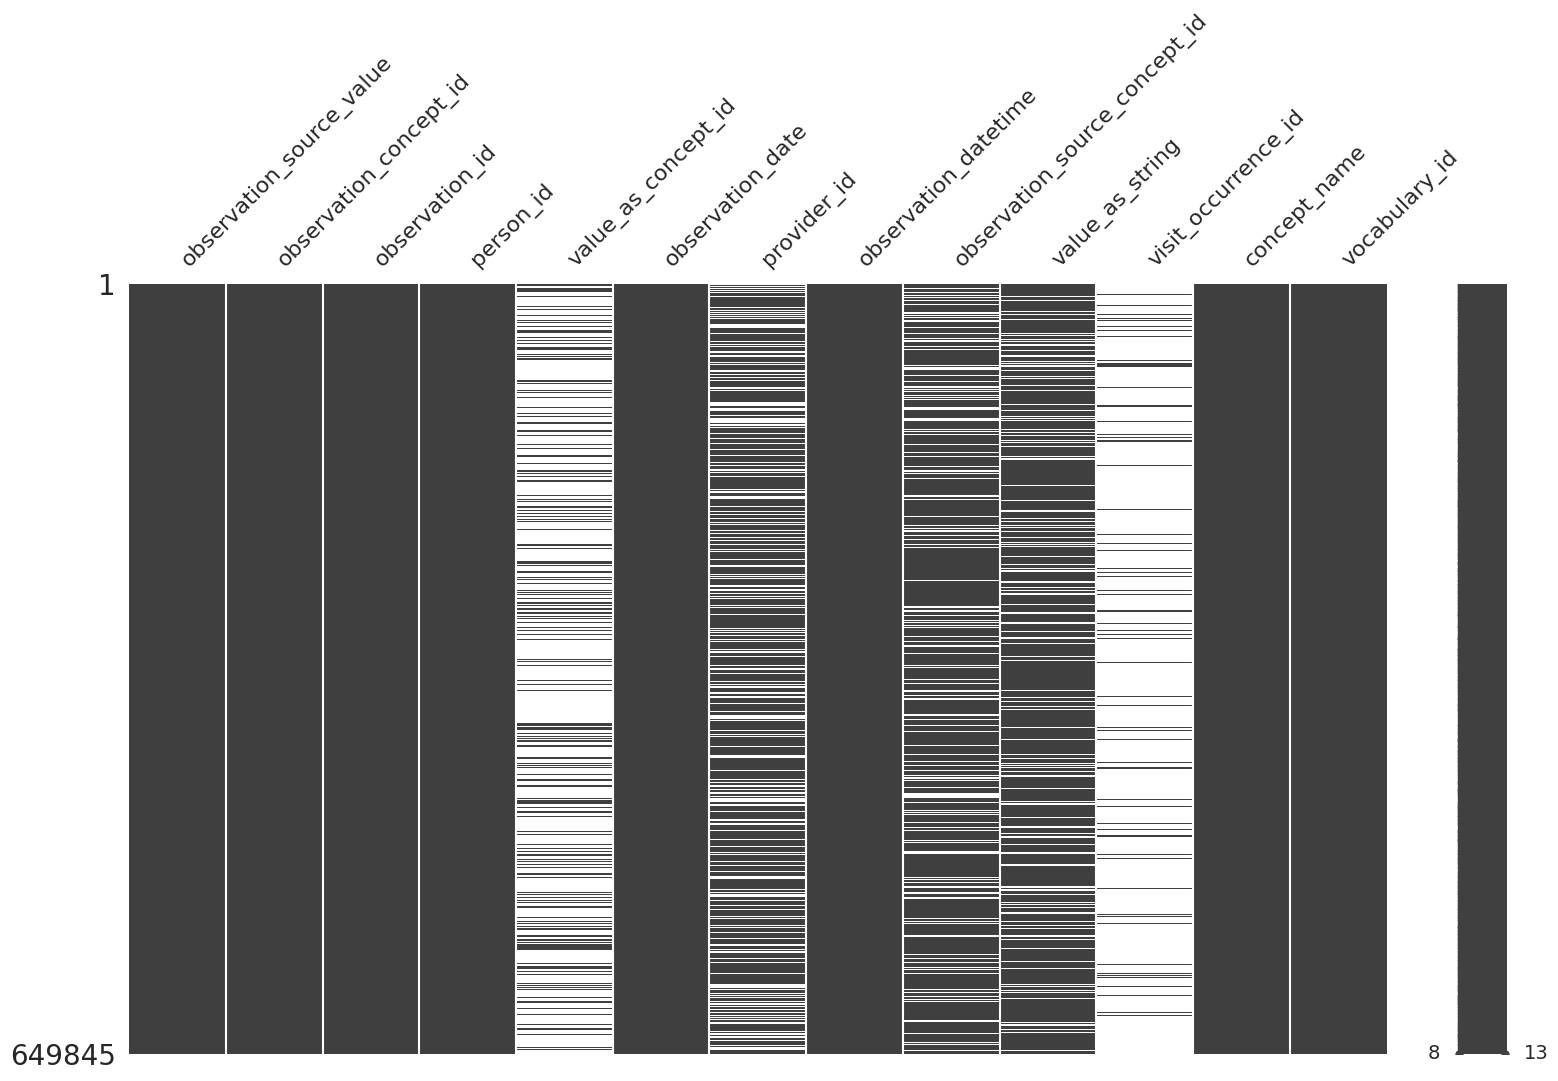

In [85]:
#Visualize cleaned dataset
import missingno as msno
msno.matrix(observations_with_names, figsize=(18, 10))

In [86]:
observations_with_names

,observation_source_value,observation_concept_id,observation_id,person_id,value_as_concept_id,observation_date,provider_id,observation_datetime,observation_source_concept_id,value_as_string,visit_occurrence_id,concept_name,vocabulary_id
0,V5861,440927.0,1000905.0,2697.0,NaN,2009-07-22,23835.0,2009-07-22 04:00:02,NaN,30-40,NaN,High risk drug monitoring status,SNOMED
1,V1046,4214956.0,1560324.0,2697.0,NaN,2008-01-24,NaN,2008-01-24 22:51:30,44820371.0,50,NaN,History of clinical finding in subject,SNOMED
3,V1083,4214956.0,383129.0,2697.0,NaN,2008-09-02,365130.0,2008-09-02 21:01:19,44827307.0,1-3,NaN,History of clinical finding in subject,SNOMED
5,V5849,4046550.0,977096.0,2697.0,4133029.0,2008-09-04,NaN,2008-09-04 13:16:02,NaN,14,3056786.0,Postoperative care,SNOMED
6,E9278,441194.0,876943.0,2697.0,NaN,2010-01-23,NaN,2010-01-23 12:50:06,44836557.0,1-3,NaN,Overexertion and strenuous movements,SNOMED
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1800614,V4501,40479553.0,400902.0,23166.0,NaN,2008-05-18,200437.0,2008-05-18 00:59:58,44823830.0,10-20,NaN,Cardiac pacemaker in situ,SNOMED
1800615,V1250,4214956.0,1443064.0,23166.0,4137906.0,2009-01-07,NaN,2009-01-07 06:34:44,44827312.0,NaN,NaN,History of clinical finding in subject,SNOMED
1800616,V5861,440927.0,1796426.0,23166.0,NaN,2008-02-09,NaN,2008-02-09 16:51:41,44831974.0,2-14,NaN,High risk drug monitoring status,SNOMED
1800620,V1002,4214956.0,1277431.0,23166.0,NaN,2008-09-30,NaN,2008-09-30 17:19:50,44829583.0,1-4,NaN,History of clinical finding in subject,SNOMED


## Austin: Drug Table Exploration
1. create a shortened path to person for test, test, and concept codes

In [87]:
drug_test = test['drug_exposure.csv']
drug_cc = cc['drug_exposure_concepts.csv']

2. Delete columnns with only NA's

In [88]:
print(drug_test.shape)
print(drug_test['person_id'].nunique())
drug_test.isna().sum()
#the folllowing columns had all NA's refills, drug_exposure_end_date, route_concept_id, lot_number, sig, route_source_value, dose_unit_source_value,drug_exposure_end_datetime, visit_detail_id, stop_reason


(151624, 23)
28484


,0
lot_number,151624
person_id,0
drug_exposure_start_datetime,6757
provider_id,128785
route_source_value,151624
drug_source_value,6757
verbatim_end_date,70131
drug_exposure_start_date,6757
stop_reason,151624
drug_exposure_end_date,151624


In [89]:
#remove columns with all NA's
drug_test.drop(columns=['refills', 'drug_exposure_end_date', 'route_concept_id', 'lot_number', 'sig', 'route_source_value', 'dose_unit_source_value', 'drug_exposure_end_datetime', 'visit_detail_id', 'stop_reason'], inplace=True)

3. Add columns for names of drug_concept_id, drug_type_concept_id, and drug_source_concept_id.
Could not find the drug_type_concept_id and drug_source_concept_id concept codes in cc table AND couldn't find them online
4. Drop source_value columns, provider_id, drug_exposure_id, visit_occurence_id, vocabulary_id

In [90]:
#convert concept dataset 'race_concept_id' data type to match the testing dataset 'race_concept_id' data type
#merge the concept table and the testing table on 'race_concept_id'
merged_drug_test = drug_test.merge(
    drug_cc,
    how='left',
    left_on='drug_concept_id',
    right_on='drug_concept_id'
)

#rename 'concept_name' column to 'race'
merged_drug_test.rename(columns={'concept_name': 'drug'}, inplace=True)

#drop extra columns
merged_drug_test.drop(columns=['vocabulary_id'], inplace=True)

merged_drug_test.head()

,person_id,drug_exposure_start_datetime,provider_id,drug_source_value,verbatim_end_date,drug_exposure_start_date,drug_type_concept_id,drug_concept_id,quantity,days_supply,drug_exposure_id,drug_source_concept_id,visit_occurrence_id,drug
0,17522.0,2009-09-08 09:08:02,NaN,55045199801,2014-11-20,2009-09-08,38000175.0,19074936.0,NaN,NaN,4921910.0,45310272.0,5338829.0,NaN
1,17522.0,2009-04-06 06:12:26,NaN,61392072860,2016-04-07,2009-04-06,38000175.0,40224903.0,30.0,90.0,3767375.0,45261566.0,1067343.0,Doxepin Hydrochloride 50 MG Oral Capsule
2,17522.0,2009-05-09 06:24:43,NaN,52959042520,2012-02-15,2009-05-09,38000175.0,1154349.0,NaN,NaN,1267223.0,44934182.0,NaN,Albuterol 2 MG Oral Tablet
3,20946.0,2008-02-16 10:24:46,NaN,24658021330,2016-10-06,2008-02-16,38000175.0,1539407.0,NaN,NaN,3277339.0,45271425.0,585796.0,Simvastatin 40 MG Oral Tablet
4,20946.0,2010-05-15 17:48:50,NaN,51079080419,NaN,2010-05-15,38000175.0,721760.0,NaN,NaN,1062101.0,44916295.0,585796.0,Nortriptyline 25 MG Oral Capsule


## Austin: Exploring Visit_Occurance Table

In [91]:
visit_test = test['visit_occurrence.csv']

visit_cc = cc['visit_occurrence_concepts.csv']

In [92]:
visit_test.head()

,visit_start_datetime,admitting_source_value,visit_end_date,person_id,visit_source_concept_id,preceding_visit_occurrence_id,visit_source_value,discharge_to_source_value,visit_occurrence_id,provider_id,care_site_id,discharge_to_concept_id,visit_start_date,admitting_source_concept_id,visit_concept_id,visit_type_concept_id,visit_end_datetime
0,2008-04-07 18:11:18,NaN,2008-04-07,6486.0,NaN,NaN,887863389355737,NaN,3170211,NaN,1329.0,NaN,2008-04-07,44814677.0,0,44818517,NaN
1,2009-11-20 06:31:35,NaN,NaN,21338.0,NaN,NaN,887413388595675,NaN,742189,NaN,294.0,NaN,2009-11-20,NaN,0,44818517,2009-11-20 20:52:29
2,2009-04-19 09:23:32,NaN,2009-04-19,44929.0,NaN,NaN,542292281552348,NaN,5008148,NaN,1160.0,44814705.0,2009-04-19,NaN,9202,44818517,NaN
3,2009-10-06 21:29:20,NaN,NaN,5500.0,NaN,NaN,887303385057354,NaN,1387313,NaN,58436.0,NaN,2009-10-06,44814681.0,0,44818517,NaN
4,2010-02-19 18:13:15,NaN,2010-02-19,22103.0,NaN,NaN,542772281347464,NaN,2804204,NaN,38930.0,NaN,2010-02-19,44814672.0,9202,44818517,2010-02-19 03:46:08


In [93]:
visit_test.nunique()

,0
visit_start_datetime,877330
admitting_source_value,0
visit_end_date,906
person_id,28484
visit_source_concept_id,0
preceding_visit_occurrence_id,0
visit_source_value,682725
discharge_to_source_value,0
visit_occurrence_id,682725
provider_id,22872


In [94]:
visit_test.isnull().sum()

,0
visit_start_datetime,0
admitting_source_value,882575
visit_end_date,458887
person_id,0
visit_source_concept_id,882575
preceding_visit_occurrence_id,882575
visit_source_value,0
discharge_to_source_value,882575
visit_occurrence_id,0
provider_id,854337


<Axes: >

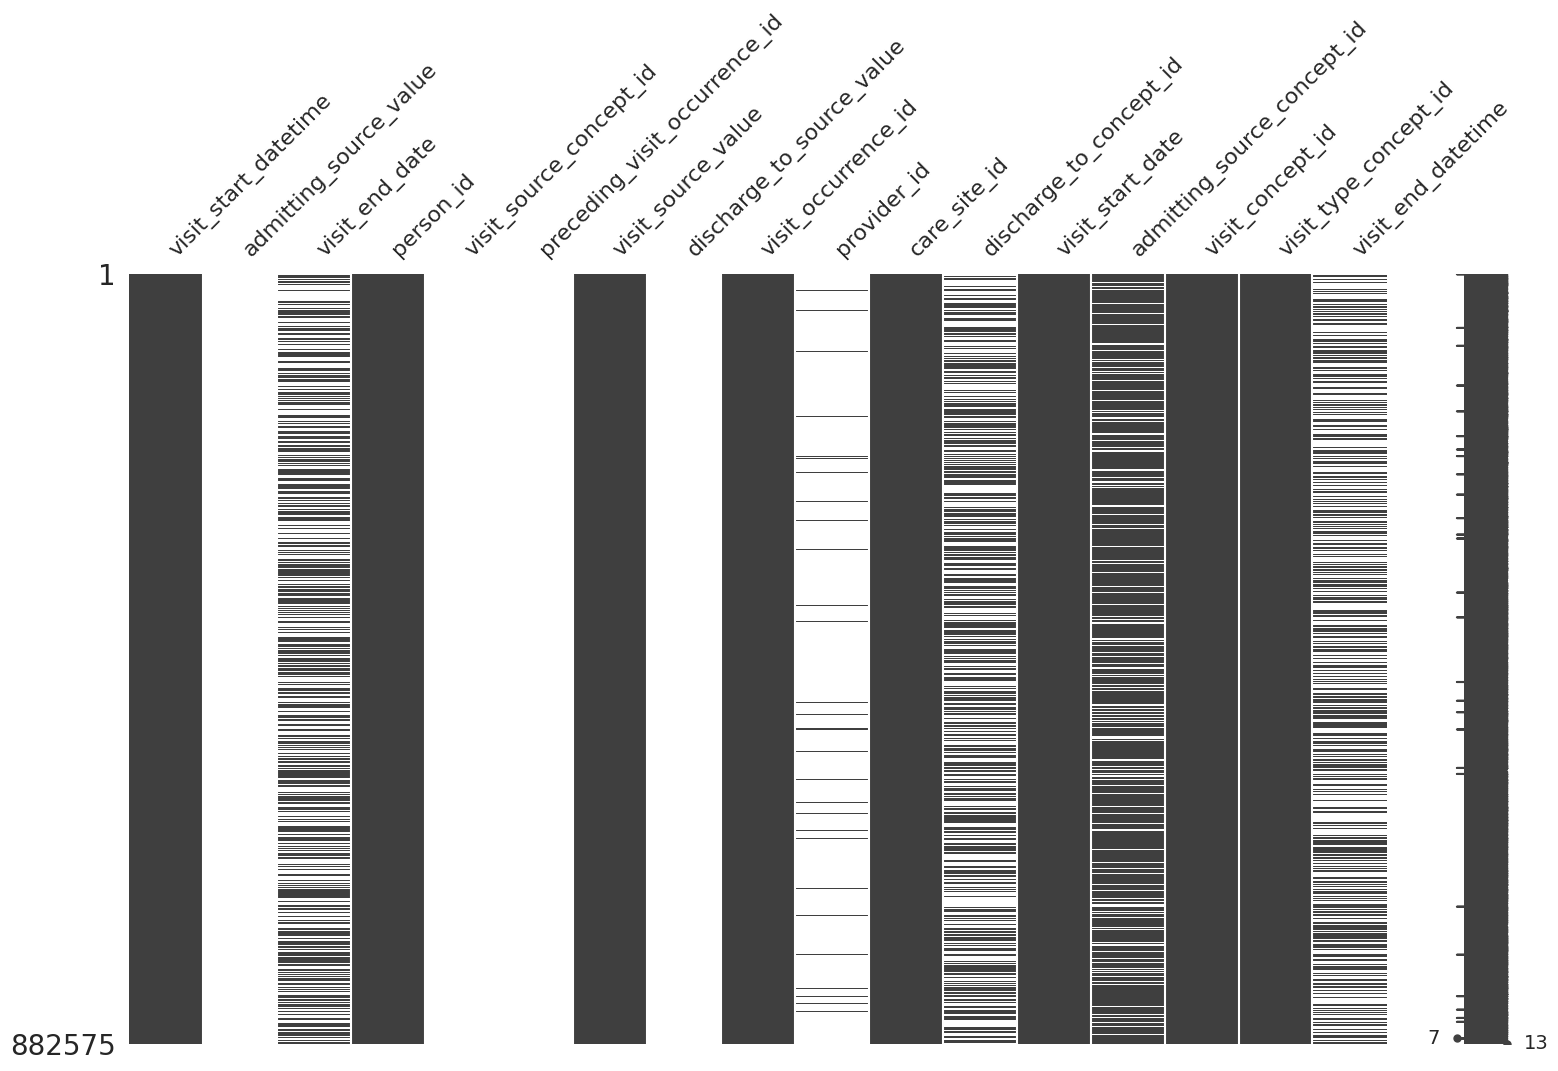

In [95]:
msno.matrix(visit_test, figsize=(18, 10))

## Natalie: Exploring Conditions Table

In [96]:
test['condition_occurrence.csv'].head()

,condition_occurrence_id,condition_start_datetime,person_id,condition_end_date,condition_end_datetime,condition_source_value,provider_id,visit_detail_id,condition_status_concept_id,condition_status_source_value,condition_concept_id,stop_reason,condition_type_concept_id,condition_start_date,condition_source_concept_id,visit_occurrence_id
0,6190193.0,2008-10-30,11741.0,NaN,NaN,40200,NaN,NaN,4230359.0,NaN,314369.0,NaN,38000230.0,2008-10-30,44827778.0,1003084.0
1,1080629.0,2008-06-11,11741.0,NaN,NaN,2720,NaN,NaN,NaN,NaN,437827.0,NaN,38000230.0,2008-06-11,44834564.0,5572242.0
2,2186035.0,2010-03-05,11741.0,NaN,NaN,49390,NaN,NaN,4230359.0,NaN,317009.0,NaN,38000230.0,2010-03-05,44821988.0,4265815.0
3,11394257.0,2008-08-28,11741.0,NaN,NaN,72619,NaN,NaN,4230359.0,NaN,79116.0,NaN,38000230.0,2008-08-28,44822220.0,2206410.0
4,10788211.0,2009-11-10,11741.0,NaN,NaN,5856,NaN,NaN,4230359.0,NaN,193782.0,NaN,38000230.0,2009-11-10,44827889.0,NaN


In [97]:
test['condition_occurrence.csv'].nunique()

,0
condition_occurrence_id,1322221
condition_start_datetime,904
person_id,28484
condition_end_date,880
condition_end_datetime,880
condition_source_value,8637
provider_id,9150
visit_detail_id,0
condition_status_concept_id,1
condition_status_source_value,0


In [98]:
test['condition_occurrence.csv'].isnull().sum()

,0
condition_occurrence_id,5720
condition_start_datetime,5720
person_id,0
condition_end_date,1581185
condition_end_datetime,1581169
condition_source_value,5720
provider_id,1576264
visit_detail_id,1586871
condition_status_concept_id,795874
condition_status_source_value,1586871


In [99]:
# Perform a left join to merge condition data with their descriptions
condition_with_names = pd.merge(
    test['condition_occurrence.csv'],
    cc['condition_occurrence_concepts.csv'],
    on='condition_concept_id',
    how='left'  # Retain all rows from condition
)

# Display the first few rows of the merged dataframe
condition_with_names

,condition_occurrence_id,condition_start_datetime,person_id,condition_end_date,condition_end_datetime,condition_source_value,provider_id,visit_detail_id,condition_status_concept_id,condition_status_source_value,condition_concept_id,stop_reason,condition_type_concept_id,condition_start_date,condition_source_concept_id,visit_occurrence_id,concept_name,vocabulary_id
0,6190193.0,2008-10-30,11741.0,NaN,NaN,40200,NaN,NaN,4230359.0,NaN,314369.0,NaN,38000230.0,2008-10-30,44827778.0,1003084.0,NaN,NaN
1,1080629.0,2008-06-11,11741.0,NaN,NaN,2720,NaN,NaN,NaN,NaN,437827.0,NaN,38000230.0,2008-06-11,44834564.0,5572242.0,Pure hypercholesterolemia,SNOMED
2,2186035.0,2010-03-05,11741.0,NaN,NaN,49390,NaN,NaN,4230359.0,NaN,317009.0,NaN,38000230.0,2010-03-05,44821988.0,4265815.0,Asthma,SNOMED
3,11394257.0,2008-08-28,11741.0,NaN,NaN,72619,NaN,NaN,4230359.0,NaN,79116.0,NaN,38000230.0,2008-08-28,44822220.0,2206410.0,Disorder of tendon of shoulder region,SNOMED
4,10788211.0,2009-11-10,11741.0,NaN,NaN,5856,NaN,NaN,4230359.0,NaN,193782.0,NaN,38000230.0,2009-11-10,44827889.0,NaN,End-stage renal disease,SNOMED
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1586866,NaN,NaN,46671.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,841516.0,NaN,NaN
1586867,NaN,NaN,46686.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1586868,NaN,NaN,46711.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1238891.0,NaN,NaN
1586869,NaN,NaN,46715.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<Axes: >

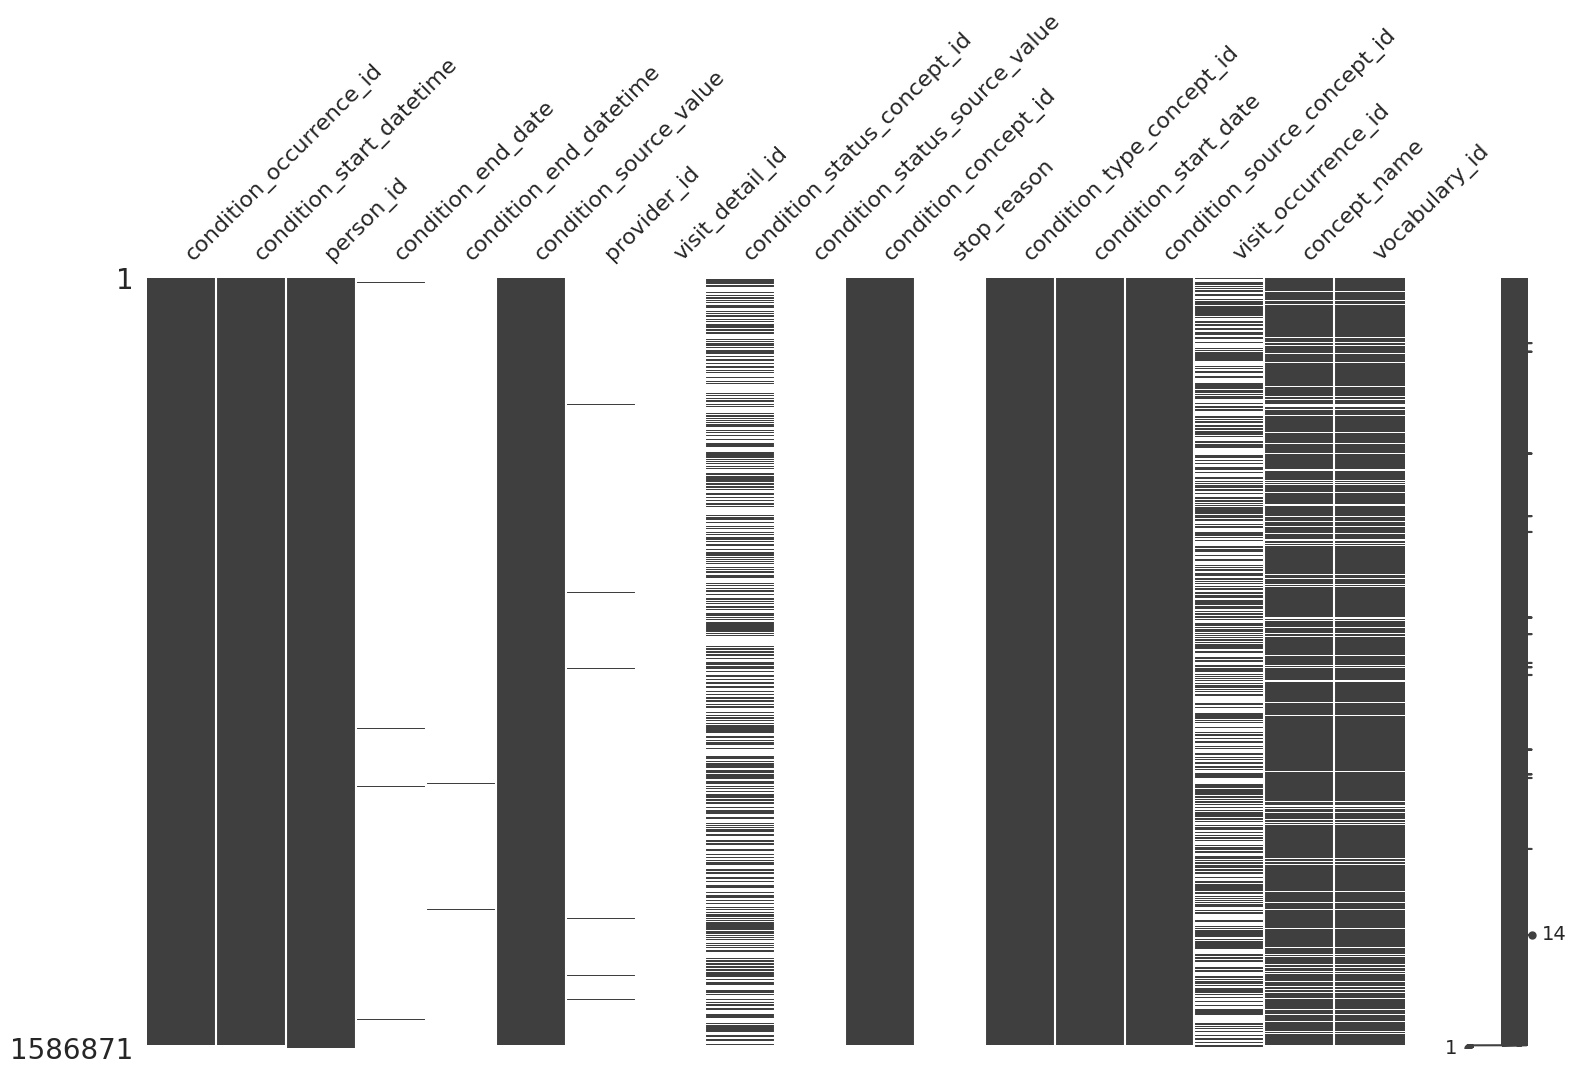

In [100]:

# Display a visualization of missing data
msno.matrix(condition_with_names, figsize=(18, 10))

## Hanane: Outcome

Here are the following steps we will take to create Table_2:


1.   Merge visit Occurence and visit Occurence concepts to get Concept_name.
2.   Drop Additional columns we wont use.
3.   Join the newly created Table with Death table.
4.   Filter to only keep the last visit date
5.   Create a New column Calculating the number of days before death
6.   Add a Binary column that states 0 if death over 180 or no death, 1 if death under 180.

In [101]:
# Load visit_occurrence and visit_occurrence_concepts datasets
visit_occurrence=test['visit_occurrence.csv']
visit_occurrence_concepts=cc['visit_occurrence_concepts.csv']

In [102]:
#join visit_occurence and visit_occurrence_concepts to find the type of visit
visit_occurrence_merge = pd.merge(visit_occurrence, visit_occurrence_concepts , on='visit_concept_id', how='outer')
visit_occurrence_merge = visit_occurrence_merge.drop(['admitting_source_value','visit_source_concept_id','preceding_visit_occurrence_id','discharge_to_source_value', 'provider_id','admitting_source_concept_id','visit_concept_id','visit_type_concept_id'], axis=1)
visit_occurrence_merge.head()

,visit_start_datetime,visit_end_date,person_id,visit_source_value,visit_occurrence_id,care_site_id,discharge_to_concept_id,visit_start_date,visit_end_datetime,concept_name,vocabulary_id
0,2008-04-07 18:11:18,2008-04-07,6486.0,8.878634e+14,3170211.0,1329.0,NaN,2008-04-07,NaN,NaN,NaN
1,2009-11-20 06:31:35,NaN,21338.0,8.874134e+14,742189.0,294.0,NaN,2009-11-20,2009-11-20 20:52:29,NaN,NaN
2,2009-10-06 21:29:20,NaN,5500.0,8.873034e+14,1387313.0,58436.0,NaN,2009-10-06,NaN,NaN,NaN
3,2009-03-12 15:43:02,NaN,16054.0,8.877534e+14,5345880.0,12077.0,44814705.0,2009-03-12,2009-03-12 18:54:42,NaN,NaN
4,2009-04-02 12:23:25,2009-04-02,35583.0,8.871034e+14,4019377.0,39784.0,NaN,2009-04-02,2009-04-02 07:41:30,NaN,NaN


In [103]:
death=test['death.csv']
death= death.drop(['death_type_concept_id','cause_concept_id','cause_source_value','cause_source_concept_id'], axis=1)
death.head()

,person_id,death_date,death_datetime
0,44486,2010-07-14,2010-07-14 20:41:10
1,1377,2011-01-25,2011-01-25 22:45:15
2,1407,2010-10-23,2010-10-23 13:16:53
3,36475,2011-04-22,2011-04-22 23:29:46
4,110,2010-07-19,2010-07-19 16:44:12


In [104]:
#Join Visit Occurrence and Death Table
Joined_visit_occurence_and_death = pd.merge(visit_occurrence_merge, death , on='person_id', how='outer')
#only keep the latest visits
# Find the latest visit for each patient
latest_visits = Joined_visit_occurence_and_death.loc[Joined_visit_occurence_and_death.groupby('person_id')['visit_start_datetime'].idxmax()]

# Reset index for a clean output
latest_visits = latest_visits.reset_index(drop=True)
latest_visits.head()

,visit_start_datetime,visit_end_date,person_id,visit_source_value,visit_occurrence_id,care_site_id,discharge_to_concept_id,visit_start_date,visit_end_datetime,concept_name,vocabulary_id,death_date,death_datetime
0,2010-05-08 01:05:14,2010-05-08,3.0,8.872634e+14,593295.0,66104.0,44814705.0,2010-05-08,NaN,NaN,NaN,NaN,NaN
1,2009-11-10 02:52:31,NaN,5.0,8.870534e+14,4451245.0,17289.0,NaN,2009-11-10,NaN,NaN,NaN,NaN,NaN
2,2010-01-21 23:29:23,2010-01-21,8.0,8.870634e+14,2653654.0,30083.0,44814705.0,2010-01-21,2010-01-21 17:42:12,NaN,NaN,NaN,NaN
3,2010-05-28 01:01:19,2010-05-28,11.0,8.874534e+14,4008695.0,9540.0,44814705.0,2010-05-28,NaN,NaN,NaN,NaN,NaN
4,2010-05-14 05:16:03,2010-05-14,12.0,8.876234e+14,997245.0,1809.0,44814705.0,2010-05-14,NaN,NaN,NaN,NaN,NaN


In [105]:
#Convert to datetime
latest_visits['visit_start_datetime'] = pd.to_datetime(latest_visits['visit_start_datetime'])

latest_visits['death_date'] = pd.to_datetime(latest_visits['death_date'])
#New column calculating difference between Death date and Lastest Visit
latest_visits['days_to_death'] = np.where(
    latest_visits['death_date'].notna(),  # death_date is not NaN
    (latest_visits['death_date'] - latest_visits['visit_start_datetime']).dt.days,  # Calculate difference in days
    np.nan  # Else, keep NaN
)

In [106]:
# Add a column for classification: 1 for True Positive, 0 for True Negative
latest_visits['classification'] = np.where(
    (latest_visits['days_to_death'] <= 180) & (latest_visits['days_to_death'].notna()),  # True Positive
    1,  # True Positive: Death within 180 days
    0   # True Negative: Death after 180 days or no death
)

# Count True Positives and True Negatives
true_positive_count = latest_visits['classification'].sum()  # Count of 1s (True Positives)
true_negative_count = len(latest_visits) - true_positive_count  # Count of 0s (True Negatives)

print(f"Number of True Positives (death within 180 days): {true_positive_count}")
print(f"Number of True Negatives (no death or death after 180 days): {true_negative_count}")


Number of True Positives (death within 180 days): 130
Number of True Negatives (no death or death after 180 days): 28354


In [107]:
# joining latest_visits and demographics
Table_2 = pd.merge(Table_1, latest_visits, on='person_id', how='outer')
Table_2

,person_id,age,gender_Male,gender_nan,race_Asian,race_Black or African American,race_Native Hawaiian or Other Pacific Islander,race_Unknown,race_White,race_nan,...,care_site_id,discharge_to_concept_id,visit_start_date,visit_end_datetime,concept_name,vocabulary_id,death_date,death_datetime,days_to_death,classification
0,3,99.0,1,0,0,0,0,0,0,0,...,66104.0,44814705.0,2010-05-08,NaN,NaN,NaN,NaT,NaN,NaN,0.0
1,5,78.0,1,0,0,0,1,0,0,0,...,17289.0,NaN,2009-11-10,NaN,NaN,NaN,NaT,NaN,NaN,0.0
2,8,96.0,1,0,0,0,0,1,0,0,...,30083.0,44814705.0,2010-01-21,2010-01-21 17:42:12,NaN,NaN,NaT,NaN,NaN,0.0
3,11,54.0,1,0,0,0,0,1,0,0,...,9540.0,44814705.0,2010-05-28,NaN,NaN,NaN,NaT,NaN,NaN,0.0
4,12,98.0,1,0,0,0,0,0,1,0,...,1809.0,44814705.0,2010-05-14,NaN,NaN,NaN,NaT,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28483,46728,105.0,1,0,0,0,0,1,0,0,...,10426.0,44814705.0,2010-05-26,2010-05-26 01:57:10,NaN,NaN,NaT,NaN,NaN,0.0
28484,46730,59.0,1,0,0,0,0,0,1,0,...,146562.0,NaN,2010-05-06,NaN,NaN,NaN,NaT,NaN,NaN,0.0
28485,46731,62.0,1,0,0,0,0,0,0,1,...,18713.0,44814705.0,2010-05-17,2010-05-17 14:27:08,NaN,NaN,NaT,NaN,NaN,0.0
28486,46732,99.0,1,0,0,0,0,0,1,0,...,305.0,NaN,2010-05-29,NaN,NaN,NaN,NaT,NaN,NaN,0.0


## Hanane: Conditions

In [108]:
#load condition occurence and concept
condition_occurrence=test['condition_occurrence.csv']
condition_occurrence_concepts=cc['condition_occurrence_concepts.csv']
# Merge the two tables to find the condition name
condition_occurrence = pd.merge(condition_occurrence, condition_occurrence_concepts, on='condition_concept_id', how='outer')
#rename 'concept_name' column to 'Condition name'
condition_occurrence.rename(columns={'concept_name': 'Condition name'}, inplace=True)
condition_occurrence.head()

,condition_occurrence_id,condition_start_datetime,person_id,condition_end_date,condition_end_datetime,condition_source_value,provider_id,visit_detail_id,condition_status_concept_id,condition_status_source_value,condition_concept_id,stop_reason,condition_type_concept_id,condition_start_date,condition_source_concept_id,visit_occurrence_id,Condition name,vocabulary_id
0,10591739.0,2009-12-13,46066.0,NaN,NaN,5859,NaN,NaN,4230359.0,NaN,0.0,NaN,38000200.0,2009-12-13,44836035.0,NaN,NaN,NaN
1,6339433.0,2009-01-10,6595.0,NaN,NaN,5715,NaN,NaN,4230359.0,NaN,0.0,NaN,38000200.0,2009-01-10,44832477.0,NaN,NaN,NaN
2,1835429.0,2008-06-04,6595.0,NaN,NaN,5859,NaN,NaN,4230359.0,NaN,0.0,NaN,38000230.0,2008-06-04,44836035.0,NaN,NaN,NaN
3,129246.0,2009-12-09,6595.0,NaN,NaN,5859,NaN,NaN,NaN,NaN,0.0,NaN,38000230.0,2009-12-09,44836035.0,NaN,NaN,NaN
4,2829301.0,2009-09-22,37089.0,NaN,NaN,41412,NaN,NaN,NaN,NaN,0.0,NaN,38000230.0,2009-09-22,44827785.0,2875783.0,NaN,NaN


In [109]:
condition_occurrence = condition_occurrence.drop(['provider_id','visit_detail_id','condition_source_concept_id','condition_status_source_value',
                                                  'condition_status_concept_id','condition_type_concept_id','condition_concept_id','stop_reason',
                                                  'condition_source_value','condition_occurrence_id','visit_occurrence_id','vocabulary_id'],axis=1)
condition_occurrence['Condition name'] = condition_occurrence['Condition name'].str.lower()
condition_occurrence.head()

,condition_start_datetime,person_id,condition_end_date,condition_end_datetime,condition_start_date,Condition name
0,2009-12-13,46066.0,NaN,NaN,2009-12-13,NaN
1,2009-01-10,6595.0,NaN,NaN,2009-01-10,NaN
2,2008-06-04,6595.0,NaN,NaN,2008-06-04,NaN
3,2009-12-09,6595.0,NaN,NaN,2009-12-09,NaN
4,2009-09-22,37089.0,NaN,NaN,2009-09-22,NaN


In [110]:
# Count the frequency of each condition name
concept_name_counts = condition_occurrence['Condition name'].value_counts()
# Display the first 10 unique concept_name values
print(concept_name_counts[:50])


Condition name
type 2 diabetes mellitus                                      64911
atrial fibrillation                                           34348
chest pain                                                    27220
pure hypercholesterolemia                                     23444
coronary arteriosclerosis in native artery                    20675
hypothyroidism                                                19124
congestive heart failure                                      18795
malaise and fatigue                                           18250
urinary tract infectious disease                              17726
low back pain                                                 17074
coronary arteriosclerosis                                     13998
dyspnea                                                       13112
pain in limb                                                  12499
abdominal pain                                                10963
end-stage renal disease          

We will pick the following Conditions


---
From Charlson Comorbidity Index
*   Myocardial infarction
*   Congestive Heart Failure
*   Peripheral vascular disease
*   Cerebrovascular accident
*   Peripheral vascular disease
*   Liver disease

Other
*   End-Stage Renal Disease
*   Stroke








In [111]:
# Define a list of keywords related to Charlson Comorbidity Index conditions
charlson_keywords = [
    'myocardial infarction',
    'congestive heart failure',
    'peripheral vascular disease',
    'cerebrovascular',
    'end-stage',
    'stroke'
    'liver'
]
# Define exclusion keywords ("without")
exclusion_keywords = ['without']

# Create a DataFrame for easier filtering
concept_name_df = concept_name_counts.reset_index()
concept_name_df.columns = ['Condition Name', 'Count']

# Keep rows where any of the keywords partially match the condition name
filtered_counts = concept_name_df[
    concept_name_df['Condition Name'].str.contains('|'.join(charlson_keywords), case=False, na=False) &
    ~ concept_name_df['Condition Name'].str.contains('|'.join(exclusion_keywords), case=False, na=False)
]

# Display the filtered results
filtered_counts



,Condition Name,Count
6,congestive heart failure,18795
14,end-stage renal disease,10471
203,acute myocardial infarction,1274
382,cerebrovascular disease,651
396,hemiplegia as late effect of cerebrovascular d...,623
562,peripheral vascular disease,408
632,late effects of cerebrovascular disease,348
644,hypertensive heart disease with congestive hea...,339
653,acute myocardial infarction of anterior wall,326
717,acute myocardial infarction of inferior wall,294


Now we will group our data

In [112]:
# Define grouping logic
def assign_group(condition_name):
    if 'myocardial infarction' in condition_name.lower():
        return 'Myocardial Infarction'
    elif 'congestive heart failure' in condition_name.lower():
        return 'Congestive Heart Failure'
    elif 'peripheral vascular disease' in condition_name.lower():
        return 'Peripheral Vascular Disease'
    elif 'cerebrovascular' in condition_name.lower() or 'stroke' in condition_name.lower() or 'hemiplegia' in condition_name.lower() or 'aphasia' in condition_name.lower():
        return 'Cerebrovascular Disease'
    elif 'end-stage' in condition_name.lower():
        return 'End-Stage Disease'
    elif 'liver' in condition_name.lower():
        return 'Liver Disease'
    else:
        return 'Other'

# Apply the grouping logic
concept_name_df['Grouped Conditions'] = concept_name_df['Condition Name'].apply(assign_group)

# Filter and group the counts as before
filtered_counts = concept_name_df[
    concept_name_df['Condition Name'].str.contains('|'.join(charlson_keywords), case=False, na=False) &
    ~ concept_name_df['Condition Name'].str.contains('|'.join(exclusion_keywords), case=False, na=False)
]

# Sort and display the results
grouped_counts = filtered_counts.groupby('Grouped Conditions').agg({'Count': 'sum'}).reset_index()

filtered_counts

,Condition Name,Count,Grouped Conditions
6,congestive heart failure,18795,Congestive Heart Failure
14,end-stage renal disease,10471,End-Stage Disease
203,acute myocardial infarction,1274,Myocardial Infarction
382,cerebrovascular disease,651,Cerebrovascular Disease
396,hemiplegia as late effect of cerebrovascular d...,623,Cerebrovascular Disease
562,peripheral vascular disease,408,Peripheral Vascular Disease
632,late effects of cerebrovascular disease,348,Cerebrovascular Disease
644,hypertensive heart disease with congestive hea...,339,Congestive Heart Failure
653,acute myocardial infarction of anterior wall,326,Myocardial Infarction
717,acute myocardial infarction of inferior wall,294,Myocardial Infarction


Note: we will pick the Condition names we are interested in drop duplicates

In [113]:
# Filter condition_occurrence for relevant conditions
filtered_conditions = condition_occurrence[
    condition_occurrence['Condition name'].str.contains('|'.join(charlson_keywords), case=False, na=False)
].copy()

# Ensure the 'Grouped Conditions' column is populated
filtered_conditions.loc[:, 'Grouped Conditions'] = filtered_conditions['Condition name'].apply(assign_group)

# Drop duplicate rows for the same person_id and Grouped Condition to ensure binary presence
filtered_conditions = filtered_conditions.drop_duplicates(subset=['person_id', 'Grouped Conditions'])

# Pivot the data: each grouped condition becomes a column, with 1 if the patient has it, 0 otherwise
condition_pivot = pd.crosstab(filtered_conditions['person_id'], filtered_conditions['Grouped Conditions'])

# Reset the index to make the DataFrame easier to work with
condition_pivot.reset_index(inplace=True)

# Display the reshaped table
condition_pivot.head()

Grouped Conditions,person_id,Cerebrovascular Disease,Congestive Heart Failure,End-Stage Disease,Myocardial Infarction,Peripheral Vascular Disease
0,8.0,0,1,0,0,0
1,11.0,0,1,1,0,0
2,13.0,1,1,1,0,0
3,15.0,1,0,0,0,0
4,16.0,0,1,0,0,0


### Merge conditions with table 2

In [114]:
# joining Table_2 and condition_pivot
Table_3 = pd.merge(Table_2, condition_pivot , on='person_id', how='outer')
Table_3 = Table_3.drop(['concept_name','vocabulary_id', 'death_date', 'death_datetime','days_to_death','visit_start_date', 'care_site_id', 'visit_occurrence_id', 'visit_source_value', 'visit_end_date',  'visit_start_datetime', 'discharge_to_concept_id', 'visit_end_datetime'],axis=1)
Table_3.head()

,person_id,age,gender_Male,gender_nan,race_Asian,race_Black or African American,race_Native Hawaiian or Other Pacific Islander,race_Unknown,race_White,race_nan,classification,Cerebrovascular Disease,Congestive Heart Failure,End-Stage Disease,Myocardial Infarction,Peripheral Vascular Disease
0,3,99.0,1,0,0,0,0,0,0,0,0.0,NaN,NaN,NaN,NaN,NaN
1,5,78.0,1,0,0,0,1,0,0,0,0.0,NaN,NaN,NaN,NaN,NaN
2,8,96.0,1,0,0,0,0,1,0,0,0.0,0.0,1.0,0.0,0.0,0.0
3,11,54.0,1,0,0,0,0,1,0,0,0.0,0.0,1.0,1.0,0.0,0.0
4,12,98.0,1,0,0,0,0,0,1,0,0.0,NaN,NaN,NaN,NaN,NaN


For the patients with no conditions after a full merge we get Nan, so I edited it to be filled 0

In [115]:
# Identify columns in Table_3 that correspond to grouped conditions
grouped_condition_columns = [col for col in Table_3.columns if col in condition_pivot.columns]

# Replace NaN with 0 in those grouped condition columns
Table_3[grouped_condition_columns] = Table_3[grouped_condition_columns].fillna(0)

# Display the updated table (optional)
Table_3.head()

,person_id,age,gender_Male,gender_nan,race_Asian,race_Black or African American,race_Native Hawaiian or Other Pacific Islander,race_Unknown,race_White,race_nan,classification,Cerebrovascular Disease,Congestive Heart Failure,End-Stage Disease,Myocardial Infarction,Peripheral Vascular Disease
0,3,99.0,1,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,5,78.0,1,0,0,0,1,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,8,96.0,1,0,0,0,0,1,0,0,0.0,0.0,1.0,0.0,0.0,0.0
3,11,54.0,1,0,0,0,0,1,0,0,0.0,0.0,1.0,1.0,0.0,0.0
4,12,98.0,1,0,0,0,0,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0


## Natalie: Extracting High Risk Admission Type

In [116]:
# Define high-risk keywords
high_risk_keywords = ['hospice', 'palliative', 'icu', 'intensive care']

# Create a binary column 'high_risk_flag' if concept_name contains any high-risk keyword
observations_with_names['high_risk_admission'] = observations_with_names['concept_name'].str.contains(
    '|'.join(high_risk_keywords), case=False, na=False
).astype(int)

# Group by person_id to ensure a single row per person with the maximum value for the high-risk flag
high_risk_flags = observations_with_names.groupby('person_id')['high_risk_admission'].max().reset_index()

# Display the resulting DataFrame with the high-risk flag
print(high_risk_flags)

       person_id  high_risk_admission
0            5.0                    0
1            8.0                    0
2           11.0                    0
3           12.0                    0
4           13.0                    0
...          ...                  ...
18572    46723.0                    0
18573    46727.0                    0
18574    46730.0                    0
18575    46732.0                    0
18576    46733.0                    0

[18577 rows x 2 columns]


<ipython-input-116-1839a5e0adce>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  observations_with_names['high_risk_admission'] = observations_with_names['concept_name'].str.contains(


In [117]:
# Filter rows where high_risk_flag is 1
high_risk_patients = high_risk_flags[high_risk_flags['high_risk_admission'] == 1]

# Display the filtered rows
print(high_risk_patients)

       person_id  high_risk_admission
10          26.0                    1
15          34.0                    1
17          36.0                    1
18          37.0                    1
20          39.0                    1
...          ...                  ...
18547    46654.0                    1
18553    46663.0                    1
18555    46668.0                    1
18556    46669.0                    1
18568    46709.0                    1

[2751 rows x 2 columns]


In [118]:
# Merge the DataFrames on 'person_id'
Table_4 = pd.merge(Table_3, high_risk_flags, on='person_id', how='left')

# Fill any missing high_risk_admission values with 0 (assuming no risk if missing)
Table_4['high_risk_admission'] = Table_4['high_risk_admission'].fillna(0)

# Display the first few rows of the updated table_2
Table_4.head()

,person_id,age,gender_Male,gender_nan,race_Asian,race_Black or African American,race_Native Hawaiian or Other Pacific Islander,race_Unknown,race_White,race_nan,classification,Cerebrovascular Disease,Congestive Heart Failure,End-Stage Disease,Myocardial Infarction,Peripheral Vascular Disease,high_risk_admission
0,3,99.0,1,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5,78.0,1,0,0,0,1,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,8,96.0,1,0,0,0,0,1,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,11,54.0,1,0,0,0,0,1,0,0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
4,12,98.0,1,0,0,0,0,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Natalie: Extracting Drugs

I first am going to generate a list of the top 1000 drugs based on frequency. I will research these outside of the notebook to generate categories of drugs that might be most relevant to our task.

In [119]:
merged_drug_test.head()

,person_id,drug_exposure_start_datetime,provider_id,drug_source_value,verbatim_end_date,drug_exposure_start_date,drug_type_concept_id,drug_concept_id,quantity,days_supply,drug_exposure_id,drug_source_concept_id,visit_occurrence_id,drug
0,17522.0,2009-09-08 09:08:02,NaN,55045199801,2014-11-20,2009-09-08,38000175.0,19074936.0,NaN,NaN,4921910.0,45310272.0,5338829.0,NaN
1,17522.0,2009-04-06 06:12:26,NaN,61392072860,2016-04-07,2009-04-06,38000175.0,40224903.0,30.0,90.0,3767375.0,45261566.0,1067343.0,Doxepin Hydrochloride 50 MG Oral Capsule
2,17522.0,2009-05-09 06:24:43,NaN,52959042520,2012-02-15,2009-05-09,38000175.0,1154349.0,NaN,NaN,1267223.0,44934182.0,NaN,Albuterol 2 MG Oral Tablet
3,20946.0,2008-02-16 10:24:46,NaN,24658021330,2016-10-06,2008-02-16,38000175.0,1539407.0,NaN,NaN,3277339.0,45271425.0,585796.0,Simvastatin 40 MG Oral Tablet
4,20946.0,2010-05-15 17:48:50,NaN,51079080419,NaN,2010-05-15,38000175.0,721760.0,NaN,NaN,1062101.0,44916295.0,585796.0,Nortriptyline 25 MG Oral Capsule


In [120]:
# Define drug categories
cancer_drugs = ['Methotrexate', 'Cyclophosphamide']
palliative_care_drugs = [
    'Midazolam', 'Haloperidol', 'Morphine', 'Fentanyl',
    'Methadone Hydrochloride', 'Oxycodone Hydrochloride', 'Hydromorphone'
]
serious_disease_drugs = [
    'Epoetin', 'Darbepoetin Alfa', 'Bumetanide',
    'Furosemide', 'Lisinopril', 'Digoxin', 'Warfarin Sodium'
]

In [121]:
# Create flags for each drug category (case insensitive)
merged_drug_test['cancer_drug'] = merged_drug_test['drug'].apply(lambda x: 1 if pd.notnull(x) and any(drug.lower() in x.lower() for drug in cancer_drugs) else 0)
merged_drug_test['palliative_care_drug'] = merged_drug_test['drug'].apply(lambda x: 1 if pd.notnull(x) and any(drug.lower() in x.lower() for drug in palliative_care_drugs) else 0)
merged_drug_test['serious_disease_drug'] = merged_drug_test['drug'].apply(lambda x: 1 if pd.notnull(x) and any(drug.lower() in x.lower() for drug in serious_disease_drugs) else 0)

In [122]:
# Group by person_id and aggregate
merged_drug_test = merged_drug_test.groupby('person_id', as_index=False).agg({
    'cancer_drug': 'max',
    'palliative_care_drug': 'max',
    'serious_disease_drug': 'max'
})
merged_drug_test

,person_id,cancer_drug,palliative_care_drug,serious_disease_drug
0,3.0,0,0,0
1,5.0,0,0,1
2,8.0,0,0,0
3,11.0,0,0,0
4,12.0,0,0,1
...,...,...,...,...
28479,46728.0,0,0,0
28480,46730.0,0,0,0
28481,46731.0,0,0,0
28482,46732.0,0,0,0


In [123]:
# Merge back with outcome dataset
Table_5 = pd.merge(Table_4, merged_drug_test, on='person_id', how='left')
Table_5

,person_id,age,gender_Male,gender_nan,race_Asian,race_Black or African American,race_Native Hawaiian or Other Pacific Islander,race_Unknown,race_White,race_nan,classification,Cerebrovascular Disease,Congestive Heart Failure,End-Stage Disease,Myocardial Infarction,Peripheral Vascular Disease,high_risk_admission,cancer_drug,palliative_care_drug,serious_disease_drug
0,3,99.0,1,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5,78.0,1,0,0,0,1,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,8,96.0,1,0,0,0,0,1,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,11,54.0,1,0,0,0,0,1,0,0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,12,98.0,1,0,0,0,0,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28483,46728,105.0,1,0,0,0,0,1,0,0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
28484,46730,59.0,1,0,0,0,0,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28485,46731,62.0,1,0,0,0,0,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28486,46732,99.0,1,0,0,0,0,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [124]:
Table_5.columns

Index(['person_id', 'age', 'gender_Male', 'gender_nan', 'race_Asian',
       'race_Black or African American',
       'race_Native Hawaiian or Other Pacific Islander', 'race_Unknown',
       'race_White', 'race_nan', 'classification', 'Cerebrovascular Disease',
       'Congestive Heart Failure', 'End-Stage Disease',
       'Myocardial Infarction', 'Peripheral Vascular Disease',
       'high_risk_admission', 'cancer_drug', 'palliative_care_drug',
       'serious_disease_drug'],
      dtype='object')

In [125]:
# dropping NAs so models can run
Table_5 = Table_5.dropna()

## Finalizing testing

In [126]:
# Create a lookup table that maps index to patient_id
lookup_table = Table_5['person_id'].reset_index()
y_test = Table_5['classification']
testing = Table_5.drop('person_id', axis=1, inplace=False)
# Display the first few rows of the lookup table and updated feature matrix





In [127]:
testing.columns

Index(['age', 'gender_Male', 'gender_nan', 'race_Asian',
       'race_Black or African American',
       'race_Native Hawaiian or Other Pacific Islander', 'race_Unknown',
       'race_White', 'race_nan', 'classification', 'Cerebrovascular Disease',
       'Congestive Heart Failure', 'End-Stage Disease',
       'Myocardial Infarction', 'Peripheral Vascular Disease',
       'high_risk_admission', 'cancer_drug', 'palliative_care_drug',
       'serious_disease_drug'],
      dtype='object')

In [128]:
demographics_feature_matrix_test = testing[['age', 'gender_Male', 'gender_nan', 'race_Asian',
       'race_Black or African American',
       'race_Native Hawaiian or Other Pacific Islander', 'race_Unknown',
       'race_White', 'race_nan',]]
conditions_and_demographics_feature_matrix_test = testing[['age', 'gender_Male', 'gender_nan', 'race_Asian',
       'race_Black or African American',
       'race_Native Hawaiian or Other Pacific Islander', 'race_Unknown',
       'race_White', 'race_nan', 'Cerebrovascular Disease',
       'Congestive Heart Failure', 'End-Stage Disease',
       'Myocardial Infarction', 'Peripheral Vascular Disease',]]
feature_matrix_test = testing[['age', 'gender_Male', 'gender_nan', 'race_Asian',
       'race_Black or African American',
       'race_Native Hawaiian or Other Pacific Islander', 'race_Unknown',
       'race_White', 'race_nan', 'Cerebrovascular Disease',
       'Congestive Heart Failure', 'End-Stage Disease',
       'Myocardial Infarction', 'Peripheral Vascular Disease',
       'high_risk_admission', 'cancer_drug', 'palliative_care_drug',
       'serious_disease_drug']]

# ML Models with Feature Group 1: Demographics

We will train the models with the feature matrix that only includes demographics (feature selection).

## Prepare Train and Test Sets

In [129]:
X_train = demographics_feature_matrix
X_test = demographics_feature_matrix_test
y_train.head()
y_test.head()

,classification
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


In [130]:
X_test.columns

Index(['age', 'gender_Male', 'gender_nan', 'race_Asian',
       'race_Black or African American',
       'race_Native Hawaiian or Other Pacific Islander', 'race_Unknown',
       'race_White', 'race_nan'],
      dtype='object')

In [131]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((97840, 9), (28480, 9), (97840,), (28480,))

In [132]:
X_train.head()

,age,gender_Male,gender_nan,race_Asian,race_Black or African American,race_Native Hawaiian or Other Pacific Islander,race_Unknown,race_White,race_nan
0,95.0,0,0,0,0,0,1,0,0
1,83.0,0,0,0,0,1,0,0,0
2,42.0,1,0,0,0,0,0,1,0
3,80.0,1,0,0,0,0,0,0,0
4,85.0,1,0,0,0,0,0,0,0


In [133]:
y_train.head()

,classification
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


In [134]:
X_test.head()

,age,gender_Male,gender_nan,race_Asian,race_Black or African American,race_Native Hawaiian or Other Pacific Islander,race_Unknown,race_White,race_nan
0,99.0,1,0,0,0,0,0,0,0
1,78.0,1,0,0,0,1,0,0,0
2,96.0,1,0,0,0,0,1,0,0
3,54.0,1,0,0,0,0,1,0,0
4,98.0,1,0,0,0,0,0,1,0


In [135]:
y_test.head()

,classification
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


In [136]:
Counter(y_train), Counter(y_test)

(Counter({0.0: 97320, 1.0: 520}), Counter({0.0: 28350, 1.0: 130}))

In [137]:
# Check for nan values in each DataFrame
print(y_train.isna().sum())
print(y_test.isna().sum())
print(X_train.isna().any().sum())
print(X_test.isna().any().sum())

0
0
0
0


In [138]:
#see diagnosis label distribution in training
y_train.value_counts()
y_train.value_counts(normalize=True)

,proportion
classification,
0.0,0.994685
1.0,0.005315


In the training data set, there are 520 deaths within 180 days and 97320 not a death within 180 days.
In the test data set, there are 130 deaths within 180 days and 28350 not a death not within 180 days.

## Train and test classification models


### Logistic Regression Model

#### Logistic Regression MLM

In [139]:
#Fit the model
model = LogisticRegression(solver='lbfgs', max_iter=5000, class_weight='balanced')
model.fit(X_train, y_train)

#Prediction
predictions_proba = model.predict_proba(X_test)
predictions = model.predict(X_test)

#### Logistic Regression Evaluation

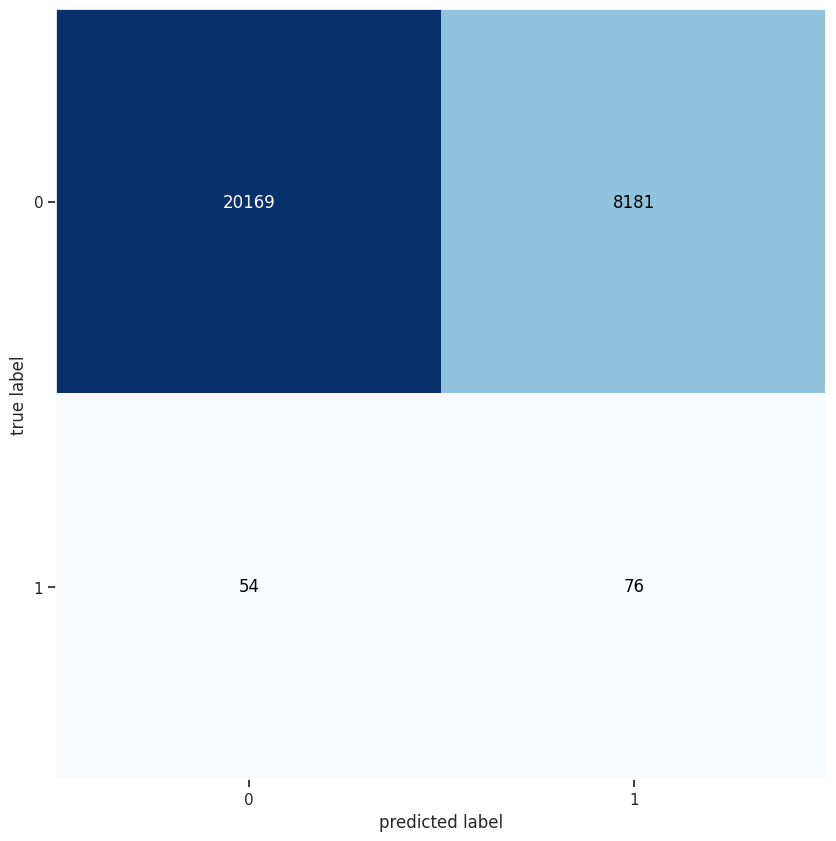

Accuracy: 0.711
Recall: 0.585
Precision: 0.009
F1: 0.018
              precision    recall  f1-score   support

         0.0       1.00      0.71      0.83     28350
         1.0       0.01      0.58      0.02       130

    accuracy                           0.71     28480
   macro avg       0.50      0.65      0.42     28480
weighted avg       0.99      0.71      0.83     28480

AUCROC: 0.683


In [140]:
#Getting the confusion matrix for the new
cm = confusion_matrix(y_test,predictions)
plot_confusion_matrix(conf_mat=cm, show_absolute=True)
plt.show()

#Accuracy
accuracy = accuracy_score(y_test, predictions)
print('Accuracy: %.3f' % accuracy)

#Recall
recall = recall_score(y_test, predictions)
print('Recall: %.3f' % recall)

#Precision
precision = precision_score(y_test, predictions)
print('Precision: %.3f' % precision)

#The f1-score is the harmonic mean of precision and recall
f1 = f1_score(y_test, predictions)
print('F1: %.3f' % f1)


#Let's print the classification
log_reg_report = classification_report(y_test, predictions)
print(log_reg_report)


#Compute and print AUC-ROC Curve
log_roc_auc = roc_auc_score(y_test, predictions_proba[:,1])
print('AUCROC: %.3f' % log_roc_auc)

### Random Forest

#### Random Forest MLM

In [ ]:
#Fit the model
model = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced_subsample',
    random_state=42
    )
model.fit(X_train, y_train)

#Prediction
predictions_proba = model.predict_proba(X_test)
predictions = model.predict(X_test)

#### Random Forrest Evaluation

In [ ]:
#Getting the confusion matrix for the new
cm = confusion_matrix(y_test,predictions)
plot_confusion_matrix(conf_mat=cm, show_absolute=True)
plt.show()

#Let's print the classification

ran_for_report = classification_report(y_test, predictions)
print(ran_for_report)

#Compute and print AUC-ROC Curve
ran_for_roc_auc = roc_auc_score(y_test, predictions_proba[:,1])
print('AUCROC: %.3f' % ran_for_roc_auc)

# ML Models with Feature Group 2: Conditions and Demographics

We will train the models with the feature matrix that only includes conditions and demographics (feature selection).

## Train and Test Sets: Splitting Data

Our training and test datasets have already been split.

In [ ]:
X_train = conditions_and_demographics_feature_matrix
X_test = conditions_and_demographics_feature_matrix_test
print(y_train.head())
print(y_test.head())

In [ ]:
X_test.columns

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

In [ ]:
X_train.head()

In [ ]:
y_train.head()

In [ ]:
X_test.head()

In [ ]:
y_test.head()

In [ ]:
#Ensuring that our data does not contain any NANs
Counter(y_train), Counter(y_test)


In the training data set, there are 520 deaths within 180 days and 97320 not a death within 180 days.
In the test data set, there are 130 deaths within 180 days and 28350 not a death not within 180 days.

In [ ]:
# see diagnosis label distribution in training
y_train.value_counts()
y_train.value_counts(normalize=True)

#There is a significant class imbalance, so we will add an class_weight argument to our models to hopefully accomodate this

## Train and test classification models


### Logistic Regression

In [ ]:
#Fit the model
model = LogisticRegression(solver='lbfgs', max_iter=5000, class_weight='balanced')
model.fit(X_train, y_train)

#Prediction
predictions_proba = model.predict_proba(X_test)
predictions = model.predict(X_test)

In [ ]:
#Getting the confusion matrix for the new
cm = confusion_matrix(y_test,predictions)
plot_confusion_matrix(conf_mat=cm, show_absolute=True)
plt.show()

#Accuracy
accuracy = accuracy_score(y_test, predictions)
print('Accuracy: %.3f' % accuracy)

#Recall
recall = recall_score(y_test, predictions)
print('Recall: %.3f' % recall)

#Precision
precision = precision_score(y_test, predictions)
print('Precision: %.3f' % precision)

#The f1-score is the harmonic mean of precision and recall
f1 = f1_score(y_test, predictions)
print('F1: %.3f' % f1)


#Let's print the classification
log_reg_report = classification_report(y_test, predictions)
print(log_reg_report)


#Compute and print AUC-ROC Curve
log_roc_auc = roc_auc_score(y_test, predictions_proba[:,1])
print('AUCROC: %.3f' % log_roc_auc)

### Random Forest

In [ ]:
#Fit the model
model2 = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced_subsample',
    random_state=42
    )
model2.fit(X_train, y_train)

#Prediction
predictions_proba = model2.predict_proba(X_test)
predictions = model2.predict(X_test)

In [ ]:
##Getting the confusion matrix for the new
cm = confusion_matrix(y_test,predictions)
plot_confusion_matrix(conf_mat=cm, show_absolute=True)
plt.show()

#Let's print the classification

ran_for_report = classification_report(y_test, predictions)
print(ran_for_report)

#Compute and print AUC-ROC Curve
ran_for_roc_auc = roc_auc_score(y_test, predictions_proba[:,1])
print('AUCROC: %.3f' % ran_for_roc_auc)

# ML Models with Feature Group 3: Full Feature Matrix

We will train the models with the full feature matrix that inclues conditions, demographics, drugs, and high_risk_admission

In [ ]:
X_train = feature_matrix
X_test = feature_matrix_test

### Logistic Regression Model

#### Logistic Regression MLM

In [ ]:
#Fit the model
model = LogisticRegression(solver='lbfgs', max_iter=5000, class_weight='balanced')
model.fit(X_train, y_train)

#Prediction
predictions_proba = model.predict_proba(X_test)
predictions = model.predict(X_test)

#### Logistic Regression Evaluation

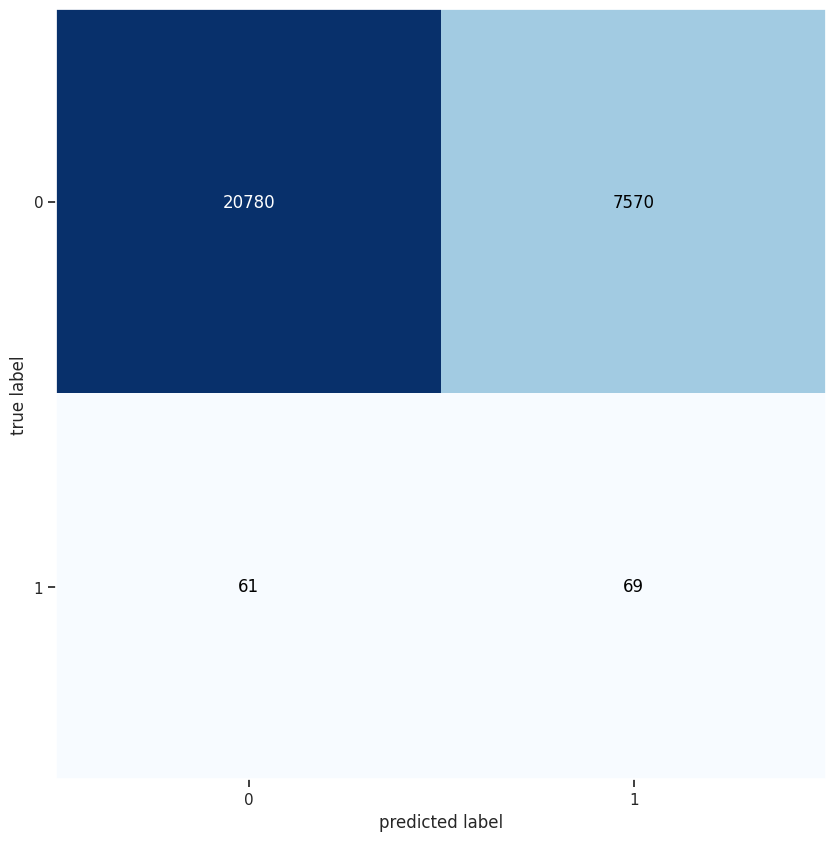

Accuracy: 0.732
Recall: 0.531
Precision: 0.009
F1: 0.018
              precision    recall  f1-score   support

         0.0       1.00      0.73      0.84     28350
         1.0       0.01      0.53      0.02       130

    accuracy                           0.73     28480
   macro avg       0.50      0.63      0.43     28480
weighted avg       0.99      0.73      0.84     28480

AUCROC: 0.657


In [ ]:
#Getting the confusion matrix for the new
cm = confusion_matrix(y_test,predictions)
plot_confusion_matrix(conf_mat=cm, show_absolute=True)
plt.show()

#Accuracy
accuracy = accuracy_score(y_test, predictions)
print('Accuracy: %.3f' % accuracy)

#Recall
recall = recall_score(y_test, predictions)
print('Recall: %.3f' % recall)

#Precision
precision = precision_score(y_test, predictions)
print('Precision: %.3f' % precision)

#The f1-score is the harmonic mean of precision and recall
f1 = f1_score(y_test, predictions)
print('F1: %.3f' % f1)


#Let's print the classification
log_reg_report = classification_report(y_test, predictions)
print(log_reg_report)


#Compute and print AUC-ROC Curve
log_roc_auc = roc_auc_score(y_test, predictions_proba[:,1])
print('AUCROC: %.3f' % log_roc_auc)

### Random Forest

#### Random Forrest MLM

In [ ]:
#Fit the model
model = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced_subsample',
    random_state=42
    )
model.fit(X_train, y_train)

#Prediction
predictions_proba = model.predict_proba(X_test)
predictions = model.predict(X_test)

#### Random Forrest Evaluation

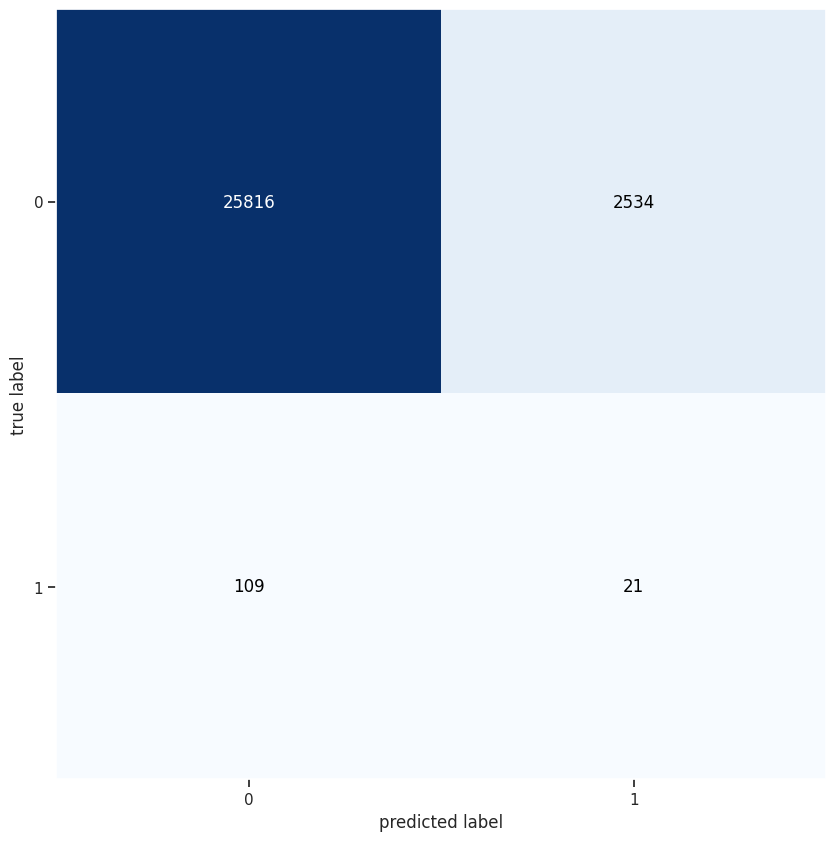

              precision    recall  f1-score   support

         0.0       1.00      0.91      0.95     28350
         1.0       0.01      0.16      0.02       130

    accuracy                           0.91     28480
   macro avg       0.50      0.54      0.48     28480
weighted avg       0.99      0.91      0.95     28480

AUCROC: 0.542


In [ ]:
#Getting the confusion matrix for the new
cm = confusion_matrix(y_test,predictions)
plot_confusion_matrix(conf_mat=cm, show_absolute=True)
plt.show()

#Let's print the classification

ran_for_report = classification_report(y_test, predictions)
print(ran_for_report)

#Compute and print AUC-ROC Curve
ran_for_roc_auc = roc_auc_score(y_test, predictions_proba[:,1])
print('AUCROC: %.3f' % ran_for_roc_auc)

# Hyperparameter Tuning


Here we optimized hyperparameters for the Random Forest Model for Group 1 which contained the demographics feature matrix (age, gender, race)



In [ ]:
X_train = demographics_feature_matrix
X_test = demographics_feature_matrix_test

### Grid Search

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt']
}

# Instantiate the Random Forest model
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')

# Instantiate GridSearchCV
rf_grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=rf_param_grid,
    scoring='roc_auc',  # Use AUC-ROC for evaluation
    cv=5,  # 5-fold cross-validation
    n_jobs=-1,  # Use all available cores
    verbose=2  # Show detailed output
)

# Fit the model
rf_grid_search.fit(X_train, y_train)

# Display the best parameters and the corresponding score
print("Best Parameters for Random Forest:", rf_grid_search.best_params_)
print("Best AUC-ROC for Random Forest:", rf_grid_search.best_score_)


Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Parameters for Random Forest: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Best AUC-ROC for Random Forest: 0.6592437418982579


### Rerunning the Random Forest Model with optimized parameters

#### Random Forest MLM

In [ ]:
#Fit the model
model = RandomForestClassifier(
    max_depth=10,
    max_features='sqrt',
    min_samples_leaf=1,
    min_samples_split=5,
    n_estimators=100,
    class_weight='balanced_subsample',
    random_state=42
)
model.fit(X_train, y_train)

#Prediction
predictions_proba = model.predict_proba(X_test)
predictions = model.predict(X_test)

#### Random Forrest Evaluation

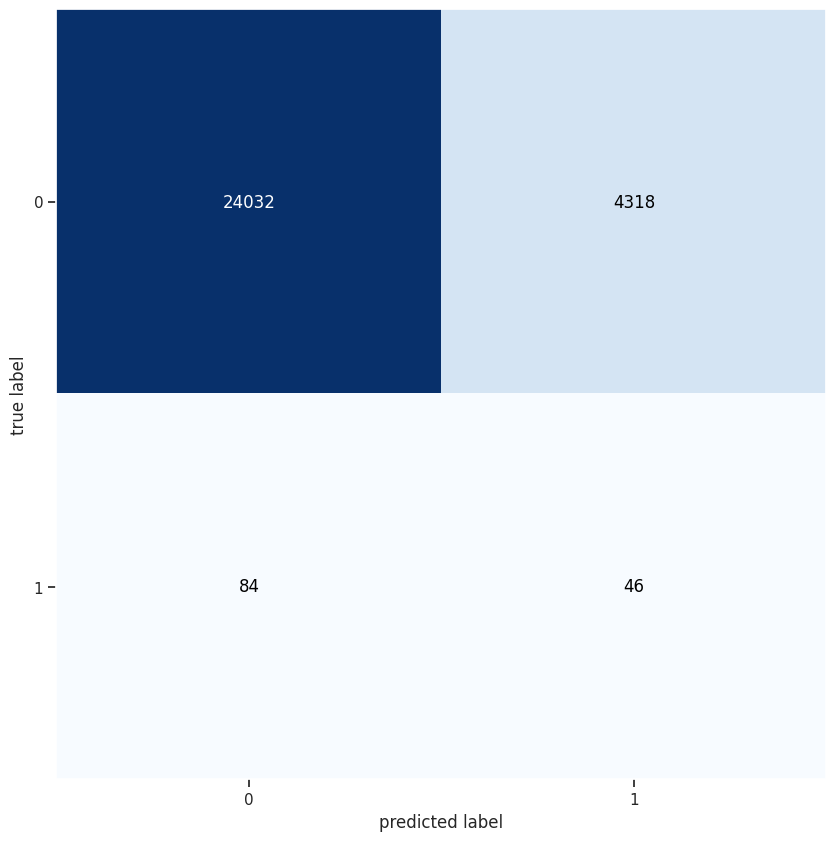

              precision    recall  f1-score   support

         0.0       1.00      0.85      0.92     28350
         1.0       0.01      0.35      0.02       130

    accuracy                           0.85     28480
   macro avg       0.50      0.60      0.47     28480
weighted avg       0.99      0.85      0.91     28480

AUCROC: 0.652


In [ ]:
#Getting the confusion matrix for the new
cm = confusion_matrix(y_test,predictions)
plot_confusion_matrix(conf_mat=cm, show_absolute=True)
plt.show()

#Let's print the classification

ran_for_report = classification_report(y_test, predictions)
print(ran_for_report)

#Compute and print AUC-ROC Curve
ran_for_roc_auc = roc_auc_score(y_test, predictions_proba[:,1])
print('AUCROC: %.3f' % ran_for_roc_auc)

# Feature Importance

After optimizing the Group 1 Random Forest Model,
we decided to find out which features are the most important.
<br>
We checked for two types of **Feature Importance:**






*   Impurity-Based Importance:
 * Will show which features most reduce impurity in decision trees.
 * Tends to be fast but may overemphasize features with high cardinality.
*   Permutation-Based Importance:
 * Reflects the impact of features on the model's performance.
 * More computationally expensive but unbiased toward specific feature properties.




## Impurity-Based Feature Importance

Feature Importances:
age                                               0.909173
gender_Male                                       0.028576
race_Unknown                                      0.012346
race_White                                        0.010913
race_Black or African American                    0.010541
race_Asian                                        0.009782
race_Native Hawaiian or Other Pacific Islander    0.009542
race_nan                                          0.009127
gender_nan                                        0.000000
dtype: float64


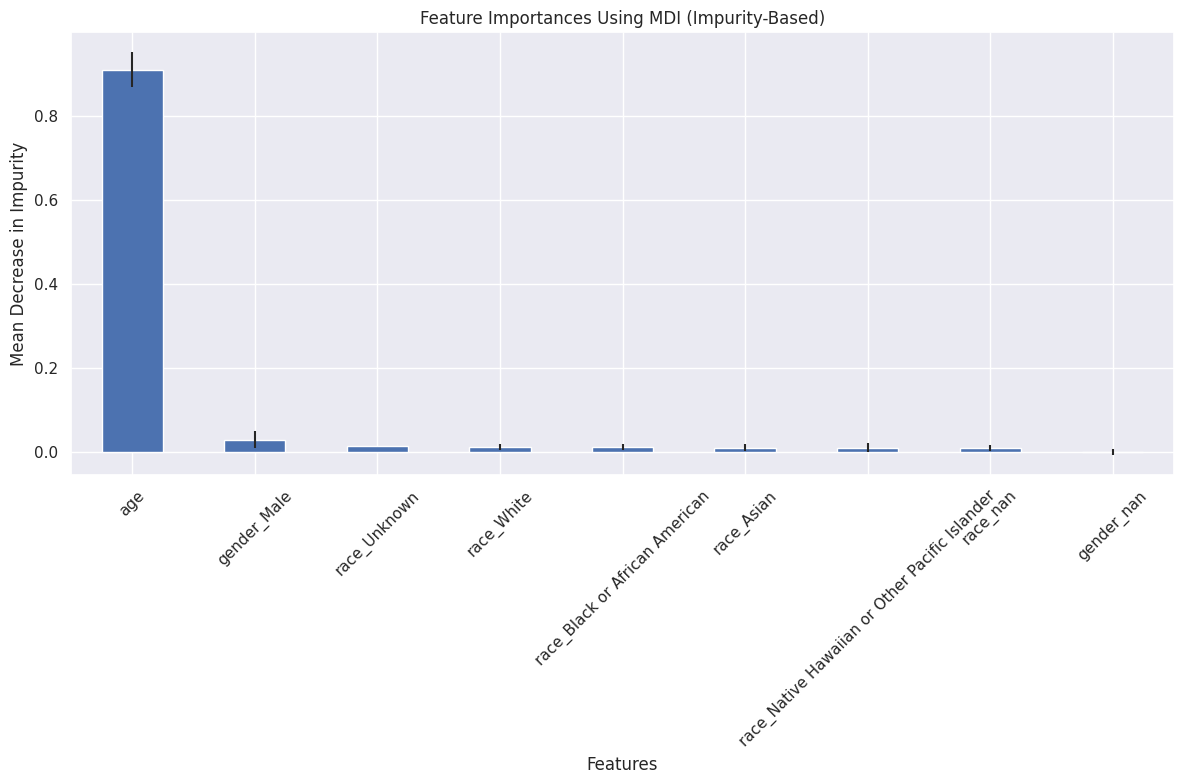

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Calculate impurity-based feature importances
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)

# Use actual feature names if X_train is a DataFrame
if hasattr(X_train, 'columns'):
    feature_names = X_train.columns
else:
    # Manually define feature names if using a numpy array
    feature_names = [f"feature {i}" for i in range(X_train.shape[1])]

# Create a pandas Series for plotting
forest_importances = pd.Series(importances, index=feature_names)

# Print the feature importances
print("Feature Importances:")
print(forest_importances.sort_values(ascending=False))

# Plot the feature importances
fig, ax = plt.subplots(figsize=(12, 8))
forest_importances.sort_values(ascending=False).plot.bar(yerr=std, ax=ax)
ax.set_title("Feature Importances Using MDI (Impurity-Based)")
ax.set_ylabel("Mean Decrease in Impurity")
ax.set_xlabel("Features")
plt.xticks(rotation=45)
fig.tight_layout()
plt.show()


## Permutation-Based Feature Importance

Permutation-Based Feature Importances:
age                                               0.002897
gender_Male                                       0.001046
gender_nan                                        0.000000
race_Native Hawaiian or Other Pacific Islander   -0.000439
race_Asian                                       -0.002395
race_White                                       -0.002953
race_Black or African American                   -0.003027
race_nan                                         -0.003118
race_Unknown                                     -0.008230
dtype: float64


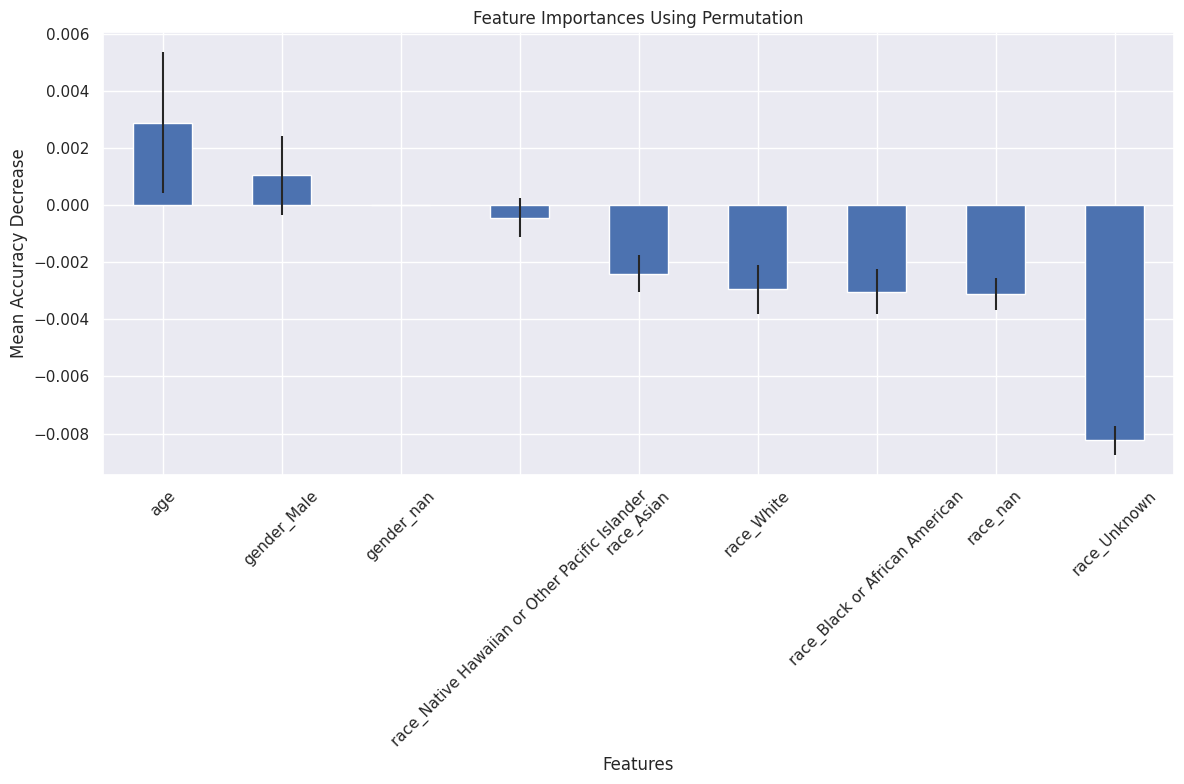

In [ ]:
from sklearn.inspection import permutation_importance
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Calculate permutation-based feature importances
result = permutation_importance(
    model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1
)

# Use actual feature names if X_train is a DataFrame
if hasattr(X_train, 'columns'):
    feature_names = X_train.columns
else:
    # Manually define feature names if using a numpy array
    feature_names = [f"feature {i}" for i in range(X_train.shape[1])]

# Create a pandas Series for the permutation importances
perm_importances = pd.Series(result.importances_mean, index=feature_names)

# Print the permutation-based feature importances
print("Permutation-Based Feature Importances:")
print(perm_importances.sort_values(ascending=False))

# Plot the permutation-based feature importances
fig, ax = plt.subplots(figsize=(12, 8))
perm_importances.sort_values(ascending=False).plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature Importances Using Permutation")
ax.set_ylabel("Mean Accuracy Decrease")
ax.set_xlabel("Features")
plt.xticks(rotation=45)
fig.tight_layout()
plt.show()
